In [8]:
# Install updated, compatible versions of all dependencies
!pip install --force-reinstall transformers==4.38.2 torch==2.2.1 pandas==2.2.1 nltk==3.8.1 emoji==2.10.1 wordcloud==1.9.3 gensim==4.3.3 plotly==5.20.0 scikit-learn==1.4.1.post1 statsmodels==0.14.1 scipy==1.11.4

  Using cached transformers-4.38.2-py3-none-any.whl.metadata (130 kB)
  Using cached torch-2.2.1-cp311-none-macosx_11_0_arm64.whl.metadata (25 kB)
  Using cached pandas-2.2.1-cp311-cp311-macosx_11_0_arm64.whl.metadata (19 kB)
  Using cached nltk-3.8.1-py3-none-any.whl.metadata (2.8 kB)
  Using cached emoji-2.10.1-py2.py3-none-any.whl.metadata (5.3 kB)
  Using cached wordcloud-1.9.3-cp311-cp311-macosx_11_0_arm64.whl.metadata (3.4 kB)
  Using cached gensim-4.3.3-cp311-cp311-macosx_11_0_arm64.whl.metadata (8.1 kB)
  Using cached plotly-5.20.0-py3-none-any.whl.metadata (7.0 kB)
  Using cached scikit_learn-1.4.1.post1-cp311-cp311-macosx_12_0_arm64.whl.metadata (11 kB)
  Using cached statsmodels-0.14.1-cp311-cp311-macosx_11_0_arm64.whl.metadata (9.5 kB)
  Using cached scipy-1.11.4-cp311-cp311-macosx_12_0_arm64.whl.metadata (165 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached huggingface_hub-0.30.1-py3-none-any.whl.metadata (13 kB)
  Using cached numpy-2.2

In [31]:
!pip install adjustText==1.2.0, spacy==3.8.4

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [32]:
# -*- coding: utf-8 -*-
"""Enhanced Student Emotion Detection Trajectory Model

This module defines a professional, intuitive class for analyzing student feedback emotions over time,
with verbose logging, advanced preprocessing, modeling, and creative visualizations for research papers.
"""

import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import emoji
from sklearn.cluster import KMeans
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import chi2_contingency
from gensim import corpora
from gensim.models import LdaModel
import plotly.express as px
import plotly.graph_objects as go  # Added missing import
import logging
import warnings
from typing import Dict, List, Optional, Tuple
from datetime import datetime
import sys
from adjustText import adjust_text  # For non-overlapping annotations

import spacy
from collections import Counter

warnings.filterwarnings('ignore')



# Import transformers after installation
from transformers import pipeline

In [11]:
# Configure logging for Colab
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s [%(levelname)s] %(message)s',
    handlers=[logging.StreamHandler(sys.stdout)]
)
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

class ColabHandler(logging.StreamHandler):
    def emit(self, record):
        super().emit(record)
        self.flush()

logger.handlers = [ColabHandler()]

In [40]:
class EmotionTrajectoryModel:
    """A professional class to analyze student feedback emotions over time with verbose logging."""

    def __init__(self, file_path: str) -> None:
        self._file_path = file_path
        self._data = None
        self._emotion_analyzer = None
        self._feedback_columns = [
            "I could have done the following to improve my performance in this course:",
            "Please identify what you consider to be the strengths of this course.",
            "Please identify areas where you think this course could be improved.",
            "What advice would you give to another student who is considering taking this course?",
            "What suggestions do you have to improve the instructor's effectiveness?"
        ]
        self._weights = dict(zip(self._feedback_columns, [0.2, 0.3, 0.3, 0.1, 0.4]))
        self._emotions = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
        self._stop_words = set(stopwords.words('english')).union({'course', 'class', 'work', 'time', 'assignment', 'student'})
        self._lemmatizer = WordNetLemmatizer()
        self._nlp = spacy.load("en_core_web_sm")  # Load spaCy model for NLP tasks
        logger.info("Initializing EmotionTrajectoryModel with file path: %s", file_path)
        self._initialize_emotion_analyzer()

    def _initialize_emotion_analyzer(self) -> None:
        logger.info("Loading emotion analyzer...")
        try:
            self._emotion_analyzer = pipeline(
                "text-classification",
                model="j-hartmann/emotion-english-distilroberta-base",
                tokenizer="j-hartmann/emotion-english-distilroberta-base",
                return_all_scores=True
            )
            logger.info("Emotion analyzer loaded successfully.")
        except Exception as e:
            logger.error("Failed to load emotion analyzer: %s. Using fallback mode.", e)
            self._emotion_analyzer = None

    def _parse_semester(self, sheet_name: str) -> Tuple[pd.Timestamp, Optional[str]]:
        logger.debug("Parsing semester from sheet name: %s", sheet_name)
        match = re.match(r'Course #\d+ (\d{2})(\d{2})', sheet_name)
        if match:
            year = 2000 + int(match.group(1))
            semester_code = int(match.group(2))
            if semester_code == 10:
                return pd.Timestamp(f"{year}-02-01"), f'Spring {year}'
            elif semester_code == 80:
                return pd.Timestamp(f"{year}-09-01"), f'Fall {year}'
        logger.warning("Invalid semester code in sheet name: %s", sheet_name)
        return pd.NaT, None

    def _preprocess_text(self, text: str) -> str:
        if pd.isna(text) or text == '':
            return ''
        text = emoji.demojize(text, delimiters=("", ""))
        text = re.sub(r'redacted|a-zredacted|redacteda-z|\[redacted\]|\{redacted\}|\{redacted\]|\[redacted\}', '', text, flags=re.IGNORECASE)
        text = text.lower()
        text = re.sub(r'[^a-z\s!.?]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def _preprocess_for_lda(self, text: str) -> List[str]:
        if pd.isna(text) or text == '':
            return []
        tokens = word_tokenize(text.lower())
        tokens = [self._lemmatizer.lemmatize(token) for token in tokens if token not in self._stop_words and len(token) > 2]
        return tokens

    def load_and_preprocess_data(self) -> None:
        logger.info("Loading and preprocessing data from %s", self._file_path)
        all_sheets = pd.read_excel(self._file_path, sheet_name=None)
        logger.info("Loaded sheets: %s", list(all_sheets.keys()))

        df_list = []
        for sheet_name, df in all_sheets.items():
            logger.debug("Processing sheet: %s", sheet_name)
            df['Date'], df['Term'] = self._parse_semester(sheet_name)
            df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
            df['course_semester'] = sheet_name
            df_list.append(df)

        self._data = pd.concat(df_list, ignore_index=True)
        self._data = self._data.sort_values(by='Date').reset_index(drop=True)
        logger.info("Data loaded and sorted. Null values per column:\n%s", self._data.isnull().sum())

        for column in self._feedback_columns:
            logger.debug("Preprocessing column: %s", column)
            self._data[column] = self._data[column].apply(self._preprocess_text)

        self._data[self._feedback_columns] = self._data[self._feedback_columns].fillna('')
        self._data['Combined_Feedback'] = self._data[self._feedback_columns].apply(
            lambda row: '. '.join([row[col] for col in self._feedback_columns if row[col]]), axis=1
        )
        output_path = 'output_preprocessed_enhanced.xlsx'
        self._data.to_excel(output_path, index=False)
        logger.info("Preprocessed data saved to %s", output_path)

    def _analyze_emotions(self, text: str) -> Dict[str, float]:
        if not self._emotion_analyzer or not text or pd.isna(text) or text.strip() == '':
            return {'label': 'neutral', 'score': 0.0, 'distribution': {e: 0.0 for e in self._emotions}}
        try:
            sentences = sent_tokenize(text)
            all_results = []
            for sent in sentences:
                if len(sent) > 512:
                    chunks = [sent[i:i+512] for i in range(0, len(sent), 256)]
                    results = [self._emotion_analyzer(chunk) for chunk in chunks]
                    avg_dist = {emotion: np.mean([r[0][i]['score'] for r in results for i, e in enumerate(r[0]) if e['label'] == emotion])
                                for emotion in self._emotions}
                    dominant = max(avg_dist.items(), key=lambda x: x[1])
                    all_results.append({'label': dominant[0], 'score': dominant[1], 'distribution': avg_dist})
                else:
                    result = self._emotion_analyzer(sent)
                    dominant = max(result[0], key=lambda x: x['score'])
                    dist = {e['label']: e['score'] for e in result[0]}
                    all_results.append({'label': dominant['label'], 'score': dominant['score'], 'distribution': dist})
            avg_dist = {emotion: np.mean([r['distribution'][emotion] for r in all_results]) for emotion in all_results[0]['distribution']}
            dominant = max(avg_dist.items(), key=lambda x: x[1])
            return {'label': dominant[0], 'score': dominant[1], 'distribution': avg_dist}
        except Exception as e:
            logger.error("Error analyzing emotions: %s", e)
            return {'label': 'neutral', 'score': 0.0, 'distribution': {e: 0.0 for e in self._emotions}}

    def analyze_emotions(self) -> None:
        logger.info("Starting emotion analysis on combined feedback...")
        emotion_results = self._data['Combined_Feedback'].apply(self._analyze_emotions)
        self._data['Combined_Emotion'] = emotion_results.apply(lambda x: x['label'])
        self._data['Combined_Emotion_Score'] = emotion_results.apply(lambda x: x['score'])
        for emotion in self._emotions:
            self._data[f'Combined_{emotion}_score'] = emotion_results.apply(lambda x: x['distribution'][emotion])
        output_path = 'Enhanced_Emotions.xlsx'
        self._data.to_excel(output_path, index=False)
        logger.info("Emotion analysis completed. Results saved to %s", output_path)

    def compute_trends(self) -> pd.DataFrame:
        logger.info("Computing emotion trends over terms...")
        terms = self._data['Term'].unique()
        emotion_trend = []
        for emotion in self._emotions:
            for term in terms:
                term_data = self._data[self._data['Term'] == term]
                total = term_data['Combined_Emotion'].value_counts().sum()
                count = term_data[term_data['Combined_Emotion'] == emotion].shape[0]
                percentage = (count / total) * 100 if total > 0 else 0
                emotion_trend.append({"Term": term, "Emotion": emotion, "Count": count, "Percentage": percentage})
        trends_df = pd.DataFrame(emotion_trend)
        logger.info("Emotion trends computed successfully.")
        return trends_df

    def predict_trends(self, emotion_trend: pd.DataFrame) -> Dict[str, List[float]]:
        logger.info("Predicting future emotion trends with ARIMA...")
        predictions = {}
        for emotion in self._emotions:
            trend = emotion_trend[emotion_trend['Emotion'] == emotion]['Percentage']
            try:
                model = ARIMA(trend, order=(1, 1, 0))
                fit = model.fit()
                forecast = fit.forecast(steps=2)
                predictions[emotion] = forecast.tolist()
                logger.info("Forecast for %s: %s", emotion, forecast.tolist())
            except Exception as e:
                logger.warning("ARIMA failed for %s: %s", emotion, e)
                predictions[emotion] = [np.nan, np.nan]

        pred_df = pd.DataFrame(predictions, index=['Next Term 1', 'Next Term 2'])
        output_path = 'ARIMA_Predictions.csv'
        pred_df.to_csv(output_path)
        logger.info("ARIMA predictions saved to %s", output_path)
        logger.info("Summary of ARIMA Forecasts:\n%s", pred_df.to_string())
        return predictions

    def validate_trends(self) -> float:
        logger.info("Validating emotion trends with chi-square test...")
        contingency_table = pd.crosstab(self._data['Term'], self._data['Combined_Emotion'])
        chi2, p, _, _ = chi2_contingency(contingency_table)
        logger.info("Chi-square test p-value: %.4f (significant if < 0.05)", p)
        return p

    def cluster_students(self) -> None:
        logger.info("Clustering students based on emotion profiles...")
        emotion_scores = self._data[[f'Combined_{e}_score' for e in self._emotions]].values
        kmeans = KMeans(n_clusters=3, random_state=42)
        self._data['Cluster'] = kmeans.fit_predict(emotion_scores)
        logger.info("Cluster distribution:\n%s", self._data['Cluster'].value_counts())

    def plot_response_distribution(self) -> None:
        logger.info("Generating response distribution bar plot...")
        counts = self._data['Combined_Emotion'].value_counts()
        plt.figure(figsize=(10, 6))
        sns.barplot(x=counts.index, y=counts.values, palette='viridis')
        plt.title("Distribution of Responses by Emotion", fontsize=14)
        plt.xlabel("Emotion", fontsize=12)
        plt.ylabel("Number of Responses", fontsize=12)
        plt.xticks(rotation=45)
        plt.show()
        logger.info("Response distribution plotted successfully.")

    def plot_emotion_wheel(self) -> None:
        logger.info("Generating emotion wheels for all semesters...")
        terms = self._data['Term'].unique()
        n_terms = len(terms)
        cols = 3
        rows = (n_terms + cols - 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), subplot_kw={'projection': 'polar'})
        axes = axes.flatten() if n_terms > 1 else [axes]

        for ax, term in zip(axes, terms):
            term_data = self._data[self._data['Term'] == term]
            scores = [term_data[term_data['Combined_Emotion'] == e].shape[0] / term_data.shape[0] * 100 if term_data.shape[0] > 0 else 0
                      for e in self._emotions]
            angles = np.linspace(0, 2 * np.pi, len(self._emotions), endpoint=False)
            ax.bar(angles, scores, width=0.8, color=['red', 'green', 'purple', 'yellow', 'gray', 'blue', 'orange'], alpha=0.7)
            ax.set_xticks(angles)
            ax.set_xticklabels(self._emotions, fontsize=8)
            ax.set_title(f"{term}", fontsize=10)

        for ax in axes[n_terms:]:
            ax.set_visible(False)

        plt.suptitle("Emotion Wheels Across Semesters", fontsize=14)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
        logger.info("Emotion wheels for %d semesters plotted successfully.", n_terms)

    def analyze_word_context(self, target_word: str, emotion: str) -> pd.DataFrame:
        """
        Analyze adjectives and verbs associated with a target word for a given emotion.
        
        Args:
            target_word (str): The word to analyze (e.g., "instructor").
            emotion (str): The emotion to filter by (e.g., "joy").
        
        Returns:
            pd.DataFrame: DataFrame with associated words and their frequencies.
        """
        logger.info("Analyzing context for '%s' in emotion '%s'...", target_word, emotion)
        
        # Filter data for the specified emotion
        emotion_data = self._data[self._data['Combined_Emotion'] == emotion]
        if emotion_data.empty:
            logger.warning("No feedback found for emotion '%s'.", emotion)
            return pd.DataFrame()

        # Extract relevant feedback text
        feedback_text = emotion_data['Combined_Feedback'].tolist()
        
        # Lists to store adjectives and verbs related to the target word
        adjectives = []
        verbs = []
        
        for text in feedback_text:
            doc = self._nlp(text)
            for token in doc:
                if token.text.lower() == target_word.lower():
                    # Look for adjectives or verbs related to the target word
                    for child in token.children:
                        if child.pos_ == "ADJ":  # Adjective
                            adjectives.append(child.text.lower())
                        elif child.pos_ == "VERB":  # Verb
                            verbs.append(child.text.lower())
                    # Look at the head of the token (e.g., verb governing the noun)
                    if token.head.pos_ == "VERB":
                        verbs.append(token.head.text.lower())
        
        # Count frequencies
        adj_counts = Counter(adjectives)
        verb_counts = Counter(verbs)
        
        # Combine into a DataFrame
        context_df = pd.DataFrame({
            "Word": list(adj_counts.keys()) + list(verb_counts.keys()),
            "Type": ["Adjective"] * len(adj_counts) + ["Verb"] * len(verb_counts),
            "Frequency": list(adj_counts.values()) + list(verb_counts.values())
        })
        
        logger.info("Context analysis completed for '%s' in '%s'. Found %d adjectives and %d verbs.",
                    target_word, emotion, len(adj_counts), len(verb_counts))
        
        return context_df

    def extract_top_nouns_pronouns(self, emotion: str, top_n: int = 5) -> list:
        """
        Extract the top N nouns and pronouns for a given emotion.
        
        Args:
            emotion (str): The emotion to analyze.
            top_n (int): Number of top nouns/pronouns to return.
        
        Returns:
            list: List of top nouns/pronouns.
        """
        logger.info("Extracting top nouns/pronouns for emotion '%s'...", emotion)
        emotion_data = self._data[self._data['Combined_Emotion'] == emotion]
        if emotion_data.empty:
            logger.warning("No feedback for emotion '%s'.", emotion)
            return []
        
        text = " ".join(emotion_data['Combined_Feedback'])
        doc = self._nlp(text)
        
        # Extract nouns and pronouns, excluding stop words
        nouns_pronouns = [
            token.text.lower() for token in doc 
            if (token.pos_ in ["NOUN", "PRON"]) and (token.text.lower() not in self._stop_words)
        ]
        
        # Count frequencies and get top N
        word_counts = Counter(nouns_pronouns)
        top_words = [word for word, _ in word_counts.most_common(top_n)]
        
        logger.info("Top %d nouns/pronouns for '%s': %s", top_n, emotion, top_words)
        return top_words

    def analyze_top_nouns_pronouns(self, top_n: int = 5) -> dict:
        """
        Analyze context for top nouns/pronouns across all emotions.
        
        Args:
            top_n (int): Number of top nouns/pronouns to analyze per emotion.
        
        Returns:
            dict: Mapping of emotion to {noun/pronoun: context_df}.
        """
        logger.info("Analyzing top %d nouns/pronouns across all emotions...", top_n)
        results = {}
        
        for emotion in self._emotions:
            top_words = self.extract_top_nouns_pronouns(emotion, top_n)
            if not top_words:
                continue
            
            emotion_results = {}
            for word in top_words:
                context_df = self.analyze_word_context(word, emotion)
                if not context_df.empty:
                    emotion_results[word] = context_df
            results[emotion] = emotion_results
        
        logger.info("Analysis of top nouns/pronouns completed.")
        return results

    def plot_noun_pronoun_contexts(self, top_n: int = 5) -> None:
        """
        Plot context bar charts for top nouns/pronouns across all emotions.
        
        Args:
            top_n (int): Number of top nouns/pronouns to analyze per emotion.
        """
        results = self.analyze_top_nouns_pronouns(top_n)
        
        for emotion, word_contexts in results.items():
            for word, context_df in word_contexts.items():
                plt.figure(figsize=(12, 6))
                for word_type in ['Adjective', 'Verb']:
                    subset = context_df[context_df['Type'] == word_type]
                    plt.bar(subset['Word'], subset['Frequency'], label=word_type, alpha=0.7)
                
                plt.title(f"Context for '{word}' in '{emotion.capitalize()}' Feedback", fontsize=14)
                plt.xlabel("Associated Words", fontsize=12)
                plt.ylabel("Frequency", fontsize=12)
                plt.xticks(rotation=45)
                plt.legend()
                plt.tight_layout()
                plt.show()
                logger.info("Plotted context for '%s' in '%s'.", word, emotion)

    def plot_word_context(self, target_word: str, emotion: str) -> None:
        """
        Plot a bar chart of adjectives and verbs associated with a target word for an emotion.
        
        Args:
            target_word (str): The word to analyze (e.g., "instructor").
            emotion (str): The emotion to filter by (e.g., "joy").
        """
        context_df = self.analyze_word_context(target_word, emotion)
        if context_df.empty:
            logger.warning("No context data to plot for '%s' in '%s'.", target_word, emotion)
            return
        
        plt.figure(figsize=(12, 6))
        for word_type in ['Adjective', 'Verb']:
            subset = context_df[context_df['Type'] == word_type]
            plt.bar(subset['Word'], subset['Frequency'], label=word_type, alpha=0.7)
        
        plt.title(f"Contextual Words for '{target_word}' in '{emotion.capitalize()}' Feedback", fontsize=14)
        plt.xlabel("Associated Words", fontsize=12)
        plt.ylabel("Frequency", fontsize=12)
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()
        logger.info("Context bar chart plotted for '%s' in '%s'.", target_word, emotion)



    def plot_word_clouds(self) -> None:
        logger.info("Generating word clouds for each emotion...")
        for emotion in self._emotions:
            text = " ".join(self._data[self._data['Combined_Emotion'] == emotion]['Combined_Feedback'])
            if text:
                wc = WordCloud(width=800, height=400, background_color='white').generate(text)
                plt.figure(figsize=(10, 5))
                plt.imshow(wc, interpolation='bilinear')
                plt.axis('off')
                plt.title(f"Word Cloud for {emotion.capitalize()}")
                plt.show()
                logger.debug("Word cloud generated for %s", emotion)
        logger.info("Word clouds generation completed.")

    def generate_instructor_insights(self) -> Dict[str, str]:
        logger.info("Generating instructor insights with LDA topic modeling...")
        insights = {}
        for emotion in self._emotions:
            emo_data = self._data[self._data['Combined_Emotion'] == emotion]
            logger.info("Processing %s: %d responses", emotion.capitalize(), emo_data.shape[0])

            if emo_data.shape[0] > 5:
                logger.debug("Preprocessing %s feedback for LDA...", emotion)
                emo_texts = [self._preprocess_for_lda(doc) for doc in emo_data['Combined_Feedback'] if doc]
                emo_texts = [t for t in emo_texts if t]
                if not emo_texts:
                    insights[emotion] = f"Insufficient meaningful feedback for {emotion} after preprocessing."
                    logger.warning("No meaningful text for %s after preprocessing.", emotion)
                    continue

                logger.debug("Creating dictionary and corpus for %s...", emotion)
                dictionary = corpora.Dictionary(emo_texts)
                corpus = [dictionary.doc2bow(text) for text in emo_texts]

                logger.debug("Training LDA model for %s...", emotion)
                num_topics = min(3, len(emo_texts) // 10 + 1)
                lda = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=20, random_state=42)
                topics = lda.print_topics(num_words=7)

                top_topic = topics[0][1]
                top_words = [word.split('"')[1] for word in top_topic.split(' + ')]
                if emotion == 'joy':
                    insight = f"Joy sparkles through engaging {top_words[0]} and approachable {top_words[1]}, boosted by {top_words[2]} and {top_words[3]}."
                elif emotion == 'neutral':
                    insight = f"Neutral sentiments reflect routine {top_words[0]} and {top_words[1]}, with {top_words[2]} and {top_words[3]} noted."
                elif emotion == 'sadness':
                    insight = f"Sadness emerges from overwhelming {top_words[0]} and {top_words[1]}, tied to {top_words[2]} and {top_words[3]} challenges."
                elif emotion == 'anger':
                    insight = f"Anger flares over difficulties with {top_words[0]} and {top_words[1]}, worsened by {top_words[2]} and {top_words[3]} issues."
                elif emotion == 'disgust':
                    insight = f"Disgust surfaces from distaste for {top_words[0]} and {top_words[1]}, alongside {top_words[2]} and {top_words[3]} grievances."
                elif emotion == 'fear':
                    insight = f"Fear creeps in over daunting {top_words[0]} and {top_words[1]}, driven by {top_words[2]} and {top_words[3]} uncertainties."
                elif emotion == 'surprise':
                    insight = f"Surprise shines through unexpected {top_words[0]} and {top_words[1]}, highlighted by {top_words[2]} and {top_words[3]}."

                logger.info("Insights for %s:\nTop topics: %s\nInterpreted Insight: %s", emotion.capitalize(), topics, insight)

                mean_score = emo_data['Combined_Emotion_Score'].mean()
                if emotion in ['sadness', 'anger', 'disgust', 'fear'] and mean_score > 0.6:
                    action = f"High {emotion} (score: {mean_score:.2f}) detected—consider addressing {top_words[0]} or {top_words[1]} concerns."
                    insights[emotion] = f"{insight} {action}"
                    logger.info("Actionable Insight for %s: %s", emotion.capitalize(), action)
                else:
                    insights[emotion] = insight
            else:
                insights[emotion] = f"Too few responses ({emo_data.shape[0]}) to analyze {emotion} meaningfully."
                logger.info("Insights for %s: %s", emotion.capitalize(), insights[emotion])

        logger.info("Instructor insights generation completed.")
        return insights

    def plot_emotion_transitions(self, emotion_trend: pd.DataFrame) -> None:
        logger.info("Generating emotion transition Sankey diagram...")
        terms = self._data['Term'].unique()
        if len(terms) < 2:
            logger.warning("Insufficient terms for transition analysis. Need at least 2 terms.")
            return

        transitions = []
        labels = []
        for i in range(len(terms) - 1):
            term1_data = self._data[self._data['Term'] == terms[i]][['Combined_Emotion']]
            term2_data = self._data[self._data['Term'] == terms[i+1]][['Combined_Emotion']]
            if len(term1_data) == len(term2_data):
                for e1, e2 in zip(term1_data['Combined_Emotion'], term2_data['Combined_Emotion']):
                    src = f"{terms[i]}: {e1}"
                    tgt = f"{terms[i+1]}: {e2}"
                    if src not in labels:
                        labels.append(src)
                    if tgt not in labels:
                        labels.append(tgt)
                    transitions.append((labels.index(src), labels.index(tgt), 1))

        if not transitions:
            logger.warning("No valid transitions found for Sankey diagram.")
            return

        source, target, value = zip(*transitions)
        fig = go.Figure(data=[go.Sankey(
            node=dict(pad=15, thickness=20, line=dict(color="black", width=0.5), label=labels, color="blue"),
            link=dict(source=source, target=target, value=value, color="rgba(0, 0, 255, 0.4)")
        )])
        fig.update_layout(title_text="Emotion Transitions Across Terms", font_size=10)
        fig.show()
        logger.info("Sankey diagram plotted successfully.")

    def plot_emotion_intensity(self) -> None:
        logger.info("Generating emotion intensity box plot...")
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='Combined_Emotion', y='Combined_Emotion_Score', data=self._data, palette='Set2')
        sns.stripplot(x='Combined_Emotion', y='Combined_Emotion_Score', data=self._data, color='black', size=3, alpha=0.5)
        plt.title("Emotion Intensity Distribution", fontsize=14)
        plt.xlabel("Emotion", fontsize=12)
        plt.ylabel("Score", fontsize=12)
        plt.xticks(rotation=45)
        plt.show()
        logger.info("Emotion intensity box plot plotted successfully.")

    def plot_cluster_emotions(self) -> None:
        logger.info("Generating cluster emotion pie charts...")
        clusters = self._data['Cluster'].unique()
        fig, axes = plt.subplots(1, len(clusters), figsize=(5 * len(clusters), 5))
        if len(clusters) == 1:
            axes = [axes]

        for ax, cluster in zip(axes, clusters):
            cluster_data = self._data[self._data['Cluster'] == cluster]['Combined_Emotion'].value_counts()
            ax.pie(cluster_data, labels=cluster_data.index, autopct='%1.1f%%', colors=['red', 'green', 'purple', 'yellow', 'gray', 'blue', 'orange'],
                   explode=[0.1 if i == cluster_data.argmax() else 0 for i in range(len(cluster_data))])
            ax.set_title(f"Cluster {cluster}")

        plt.suptitle("Emotion Proportions by Cluster", fontsize=14)
        plt.tight_layout()
        plt.show()
        logger.info("Cluster emotion pie charts plotted successfully.")

    def plot_emotion_word_bubbles(self, insights: Dict[str, str]) -> None:
        logger.info("Generating emotion word bubble chart...")
        word_freq = {}
        for emotion in self._emotions:
            if emotion in insights and "Too few responses" not in insights[emotion]:
                emo_texts = [self._preprocess_for_lda(doc) for doc in self._data[self._data['Combined_Emotion'] == emotion]['Combined_Feedback'] if doc]
                flat_words = [word for sublist in emo_texts for word in sublist]
                for word in set(flat_words):
                    if word in word_freq:
                        word_freq[word][emotion] = flat_words.count(word)
                    else:
                        word_freq[word] = {e: 0 for e in self._emotions}
                        word_freq[word][emotion] = flat_words.count(word)

        if not word_freq:
            logger.warning("No words extracted for bubble chart.")
            return

        top_words = sorted(word_freq.items(), key=lambda x: sum(x[1].values()), reverse=True)[:10]
        x, y, sizes, colors = [], [], [], []
        emotion_colors = {'anger': 'red', 'disgust': 'green', 'fear': 'purple', 'joy': 'yellow',
                          'neutral': 'gray', 'sadness': 'blue', 'surprise': 'orange'}

        for i, (word, freqs) in enumerate(top_words):
            dominant_emotion = max(freqs.items(), key=lambda x: x[1])[0]
            x.append(i)
            y.append(sum(freqs.values()) / len(self._emotions))
            sizes.append(sum(freqs.values()) * 10)
            colors.append(emotion_colors[dominant_emotion])

        plt.figure(figsize=(12, 8))
        plt.scatter(x, y, s=sizes, c=colors, alpha=0.6)
        for i, word in enumerate([w[0] for w in top_words]):
            plt.annotate(word, (x[i], y[i]), fontsize=10, ha='center')
        plt.title("Key Words by Emotion (Bubble Size = Frequency)", fontsize=14)
        plt.xlabel("Word Index", fontsize=12)
        plt.ylabel("Average Frequency", fontsize=12)
        plt.show()
        logger.info("Emotion word bubble chart plotted successfully.")

    def plot_interactive_trends(self, emotion_trend: pd.DataFrame, predictions: Dict[str, List[float]]) -> None:
        logger.info("Generating interactive emotion trends plot with forecasts...")
        fig = px.line(emotion_trend, x="Term", y="Percentage", color="Emotion",
                      title="Emotion Trends Over Time with ARIMA Forecasts",
                      labels={"Percentage": "Emotion Percentage (%)", "Term": "Semester"})
        fig.update_traces(mode="lines+markers")

        terms = self._data['Term'].unique()
        last_term = terms[-1]
        forecast_terms = [f"{last_term} + {i+1}" for i in range(2)]

        for emotion in self._emotions:
            forecast_vals = predictions.get(emotion, [np.nan, np.nan])
            for term, val in zip(forecast_terms, forecast_vals):
                fig.add_trace(go.Scatter(x=[term], y=[val], mode='markers', name=f"{emotion} (Forecast)",
                                         line=dict(dash='dash'), marker=dict(symbol='x', size=10)))

        output_path = "emotion_trends_with_forecasts.html"
        fig.write_html(output_path)
        logger.info("Interactive plot with forecasts saved to %s", output_path)

    def plot_stacked_area(self, emotion_trend: pd.DataFrame) -> None:
        logger.info("Generating stacked area chart...")
        pivot_data = emotion_trend.pivot(index='Term', columns='Emotion', values='Percentage').fillna(0)
        term_date_map = self._data[['Term', 'Date']].drop_duplicates().set_index('Term')['Date']
        pivot_data = pivot_data.join(term_date_map).sort_values(by='Date').drop(columns='Date', errors='ignore')
        if pivot_data.empty:
            logger.warning("No data available for stacked area chart.")
            return
        
        plt.figure(figsize=(12, 6))
        plt.stackplot(pivot_data.index, pivot_data.T, labels=self._emotions,
                      colors=['red', 'green', 'purple', 'yellow', 'gray', 'blue', 'orange'], alpha=0.7)
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.title("Emotion Proportions Over Time", fontsize=14)
        plt.xlabel("Term", fontsize=12)
        plt.ylabel("Percentage (%)", fontsize=12)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        logger.info("Stacked area chart plotted successfully.")

    def plot_correlation_heatmap(self) -> None:
        logger.info("Generating correlation heatmap...")
        emotion_scores = self._data[[f'Combined_{e}_score' for e in self._emotions]]
        corr_matrix = emotion_scores.corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', vmin=-1, vmax=1, center=0, fmt='.2f')
        plt.title("Correlation Between Emotions", fontsize=14)
        plt.show()
        logger.info("Correlation heatmap plotted successfully.")

    def plot_radar_chart(self, emotion_trend: pd.DataFrame) -> None:
        logger.info("Generating radar chart...")
        terms = self._data['Term'].unique()
        pivot_data = emotion_trend.pivot(index='Term', columns='Emotion', values='Percentage').fillna(0)
        angles = np.linspace(0, 2 * np.pi, len(self._emotions), endpoint=False).tolist()
        angles += angles[:1]

        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
        for term in terms:
            values = pivot_data.loc[term].values.tolist()
            values += values[:1]
            ax.plot(angles, values, label=term, linewidth=2)
            ax.fill(angles, values, alpha=0.25)

        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(self._emotions)
        plt.title("Emotion Profiles Across Terms", fontsize=14)
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.show()
        logger.info("Radar chart plotted successfully.")

    def plot_timeline_with_annotations(self, emotion_trend: pd.DataFrame, insights: Dict[str, str]) -> None:
        logger.info("Generating timeline with annotations...")
        plt.figure(figsize=(14, 8))
        texts = []
        for emotion in self._emotions:
            emo_data = emotion_trend[emotion_trend['Emotion'] == emotion]
            plt.plot(emo_data['Term'], emo_data['Percentage'], marker='o', label=emotion)
            if emotion in insights and "Too few responses" not in insights[emotion]:
                max_idx = emo_data['Percentage'].idxmax()
                term = emo_data.loc[max_idx, 'Term']
                perc = emo_data.loc[max_idx, 'Percentage']
                text = plt.text(term, perc, insights[emotion], fontsize=8, ha='center', va='bottom')
                texts.append(text)

        adjust_text(texts, arrowprops=dict(arrowstyle="->", color='black', lw=0.5))
        plt.title("Emotion Timeline with Actionable Insights", fontsize=14)
        plt.xlabel("Term", fontsize=12)
        plt.ylabel("Percentage (%)", fontsize=12)
        plt.xticks(rotation=45)
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.tight_layout()
        plt.show()
        logger.info("Timeline with annotations plotted successfully.")

    def run(self) -> None:
        logger.info("Starting full emotion trajectory analysis pipeline...")
        self.load_and_preprocess_data()
        self.analyze_emotions()
        emotion_trend = self.compute_trends()
        predictions = self.predict_trends(emotion_trend)
        self.validate_trends()
        self.cluster_students()
        self.plot_response_distribution()
        self.plot_emotion_wheel()
        self.analyze_word_context("instructor", "joy")  # Example context analysis
        self.plot_word_context("instructor", "joy")  # Plotting context for "instructor" in "joy"
        self.plot_noun_pronoun_contexts(top_n=5)  # Plotting top nouns/pronouns contexts
        self.plot_word_clouds()
        insights = self.generate_instructor_insights()
        self.plot_emotion_transitions(emotion_trend)
        self.plot_emotion_intensity()
        self.plot_cluster_emotions()
        self.plot_emotion_word_bubbles(insights)
        self.plot_interactive_trends(emotion_trend, predictions)
        self.plot_stacked_area(emotion_trend)
        self.plot_correlation_heatmap()
        self.plot_radar_chart(emotion_trend)
        self.plot_timeline_with_annotations(emotion_trend, insights)
        output_path = 'Final_Enhanced_Model.xlsx'
        self._data.to_excel(output_path, index=False)
        logger.info("Pipeline completed successfully. Final data saved to %s", output_path)

In [20]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/puskarjoshi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/puskarjoshi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Initializing EmotionTrajectoryModel with file path: Sentiment Data Collection Sheet.xlsx


2025-04-01 14:57:56,293 [INFO] Initializing EmotionTrajectoryModel with file path: Sentiment Data Collection Sheet.xlsx


Loading emotion analyzer...


2025-04-01 14:57:56,295 [INFO] Loading emotion analyzer...


Emotion analyzer loaded successfully.


2025-04-01 14:57:56,894 [INFO] Emotion analyzer loaded successfully.


Starting full emotion trajectory analysis pipeline...


2025-04-01 14:57:56,895 [INFO] Starting full emotion trajectory analysis pipeline...


Loading and preprocessing data from Sentiment Data Collection Sheet.xlsx


2025-04-01 14:57:56,895 [INFO] Loading and preprocessing data from Sentiment Data Collection Sheet.xlsx


Loaded sheets: ['Course #1 2410', 'Course #2 2410', 'Course #3 2410', 'Course #4 2410', 'Course #5 2410', 'Course #6 2410', 'Course #7 2410', 'Course #8 2410', 'Course #9 2410', 'Course #10 2410', 'Course #11 2410', 'Course #12 2410', 'Course #13 2410', 'Course #14 2410', 'Course #15 2410', 'Course #16 2410', 'Course #17 2380', 'Course #18 2380', 'Course #19 2380', 'Course #20 2380', 'Course #21 2310 ', 'Course #22 2280', 'Course #23 2280', 'Course #24 2280', 'Course #25 2280', 'Course #26 2280', 'Course #27 2280', 'Course #28 2280', 'Course #29 2280', 'Course #30 2280', 'Course #31 2280', 'Course #32 2280', 'Course #33 2280', 'Course #34 2280', 'Course #35 2280', 'Course #36 2210', 'Course #37 2210', 'Course #38 2210', 'Course #39 2210', 'Course #40 2210', 'Course #41 2210', 'Course #42 2210', 'Course #43 2210', 'Course #44 2210', 'Course #45 2210', 'Course #46 2210', 'Course #47 2210', 'Course #48 2210', 'Course #49 2210', 'Course #50 2210', 'Course #51 2210', 'Course #52 2210', 'Cou

2025-04-01 14:57:57,009 [INFO] Loaded sheets: ['Course #1 2410', 'Course #2 2410', 'Course #3 2410', 'Course #4 2410', 'Course #5 2410', 'Course #6 2410', 'Course #7 2410', 'Course #8 2410', 'Course #9 2410', 'Course #10 2410', 'Course #11 2410', 'Course #12 2410', 'Course #13 2410', 'Course #14 2410', 'Course #15 2410', 'Course #16 2410', 'Course #17 2380', 'Course #18 2380', 'Course #19 2380', 'Course #20 2380', 'Course #21 2310 ', 'Course #22 2280', 'Course #23 2280', 'Course #24 2280', 'Course #25 2280', 'Course #26 2280', 'Course #27 2280', 'Course #28 2280', 'Course #29 2280', 'Course #30 2280', 'Course #31 2280', 'Course #32 2280', 'Course #33 2280', 'Course #34 2280', 'Course #35 2280', 'Course #36 2210', 'Course #37 2210', 'Course #38 2210', 'Course #39 2210', 'Course #40 2210', 'Course #41 2210', 'Course #42 2210', 'Course #43 2210', 'Course #44 2210', 'Course #45 2210', 'Course #46 2210', 'Course #47 2210', 'Course #48 2210', 'Course #49 2210', 'Course #50 2210', 'Course #51

Data loaded and sorted. Null values per column:
I could have done the following to improve my performance in this course:               142
Please identify what you consider to be the strengths of this course.                    83
Please identify areas where you think this course could be improved.                     71
What advice would you give to another student who is considering taking this course?     42
What suggestions do you have to improve the instructor's effectiveness?                 358
Date                                                                                      0
Term                                                                                      0
course_semester                                                                           0
dtype: int64


2025-04-01 14:57:57,033 [INFO] Data loaded and sorted. Null values per column:
I could have done the following to improve my performance in this course:               142
Please identify what you consider to be the strengths of this course.                    83
Please identify areas where you think this course could be improved.                     71
What advice would you give to another student who is considering taking this course?     42
What suggestions do you have to improve the instructor's effectiveness?                 358
Date                                                                                      0
Term                                                                                      0
course_semester                                                                           0
dtype: int64


Preprocessed data saved to output_preprocessed_enhanced.xlsx


2025-04-01 14:57:57,198 [INFO] Preprocessed data saved to output_preprocessed_enhanced.xlsx


Starting emotion analysis on combined feedback...


2025-04-01 14:57:57,199 [INFO] Starting emotion analysis on combined feedback...


Emotion analysis completed. Results saved to Enhanced_Emotions.xlsx


2025-04-01 14:58:29,948 [INFO] Emotion analysis completed. Results saved to Enhanced_Emotions.xlsx


Computing emotion trends over terms...


2025-04-01 14:58:29,949 [INFO] Computing emotion trends over terms...


Emotion trends computed successfully.


2025-04-01 14:58:29,968 [INFO] Emotion trends computed successfully.


Predicting future emotion trends with ARIMA...


2025-04-01 14:58:29,968 [INFO] Predicting future emotion trends with ARIMA...


Forecast for anger: [5.190415775255554, 5.533707423799694]


2025-04-01 14:58:29,977 [INFO] Forecast for anger: [5.190415775255554, 5.533707423799694]


Forecast for disgust: [0.8653496840290695, 1.6333939355564153]


2025-04-01 14:58:29,986 [INFO] Forecast for disgust: [0.8653496840290695, 1.6333939355564153]


Forecast for fear: [1.6331912364340375e-18, 1.4395100537653541e-18]


2025-04-01 14:58:29,996 [INFO] Forecast for fear: [1.6331912364340375e-18, 1.4395100537653541e-18]


Forecast for joy: [8.570985729396593, 7.563299057605741]


2025-04-01 14:58:30,008 [INFO] Forecast for joy: [8.570985729396593, 7.563299057605741]


Forecast for neutral: [73.92067981378982, 69.97412680839216]


2025-04-01 14:58:30,042 [INFO] Forecast for neutral: [73.92067981378982, 69.97412680839216]


Forecast for sadness: [7.437617702659086, 8.268053916939348]


2025-04-01 14:58:30,053 [INFO] Forecast for sadness: [7.437617702659086, 8.268053916939348]


Forecast for surprise: [10.395712261162387, 11.043517678523619]


2025-04-01 14:58:30,060 [INFO] Forecast for surprise: [10.395712261162387, 11.043517678523619]


ARIMA predictions saved to ARIMA_Predictions.csv


2025-04-01 14:58:30,061 [INFO] ARIMA predictions saved to ARIMA_Predictions.csv


Summary of ARIMA Forecasts:
                anger   disgust          fear       joy    neutral   sadness   surprise
Next Term 1  5.190416  0.865350  1.633191e-18  8.570986  73.920680  7.437618  10.395712
Next Term 2  5.533707  1.633394  1.439510e-18  7.563299  69.974127  8.268054  11.043518


2025-04-01 14:58:30,062 [INFO] Summary of ARIMA Forecasts:
                anger   disgust          fear       joy    neutral   sadness   surprise
Next Term 1  5.190416  0.865350  1.633191e-18  8.570986  73.920680  7.437618  10.395712
Next Term 2  5.533707  1.633394  1.439510e-18  7.563299  69.974127  8.268054  11.043518


Validating emotion trends with chi-square test...


2025-04-01 14:58:30,062 [INFO] Validating emotion trends with chi-square test...


Chi-square test p-value: 0.0001 (significant if < 0.05)


2025-04-01 14:58:30,065 [INFO] Chi-square test p-value: 0.0001 (significant if < 0.05)


Clustering students based on emotion profiles...


2025-04-01 14:58:30,065 [INFO] Clustering students based on emotion profiles...


Cluster distribution:
Cluster
0    350
1    255
2     86
Name: count, dtype: int64


2025-04-01 14:58:30,071 [INFO] Cluster distribution:
Cluster
0    350
1    255
2     86
Name: count, dtype: int64


Generating response distribution bar plot...


2025-04-01 14:58:30,072 [INFO] Generating response distribution bar plot...


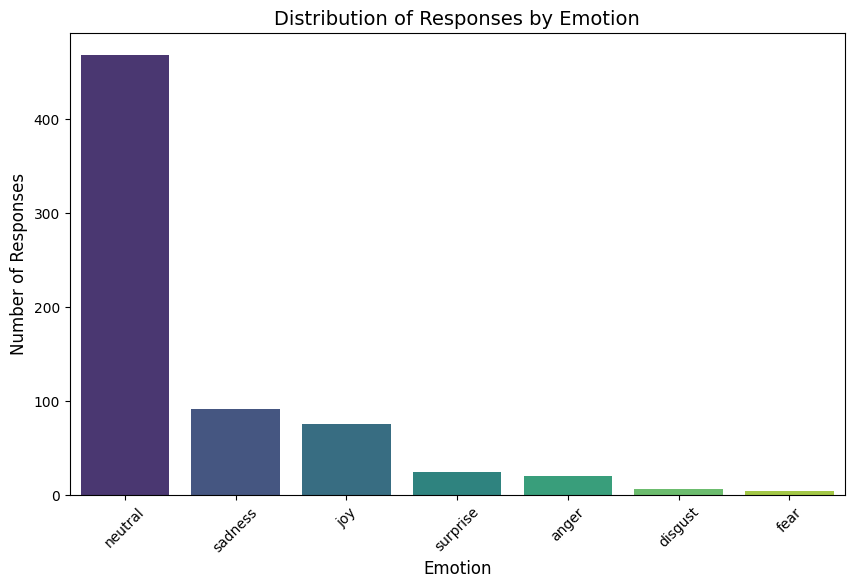

Response distribution plotted successfully.


2025-04-01 14:58:30,134 [INFO] Response distribution plotted successfully.


Generating emotion wheels for all semesters...


2025-04-01 14:58:30,135 [INFO] Generating emotion wheels for all semesters...


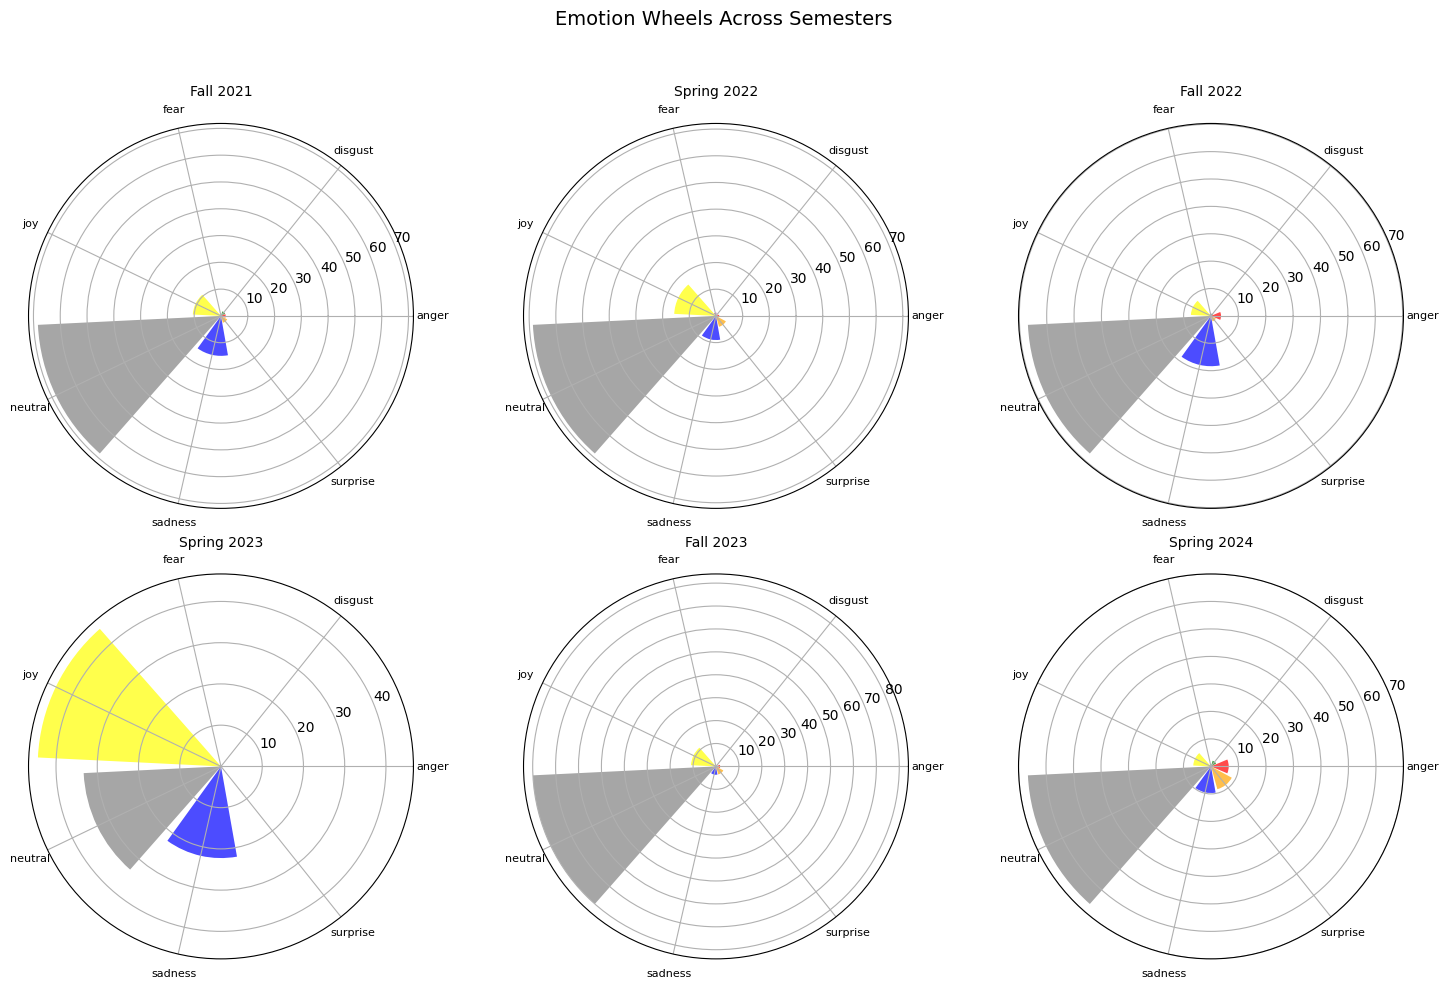

Emotion wheels for 6 semesters plotted successfully.


2025-04-01 14:58:30,571 [INFO] Emotion wheels for 6 semesters plotted successfully.


Analyzing context for 'instructor' in emotion 'joy'...


2025-04-01 14:58:30,571 [INFO] Analyzing context for 'instructor' in emotion 'joy'...


Context analysis completed for 'instructor' in 'joy'. Found 3 adjectives and 12 verbs.


2025-04-01 14:58:31,578 [INFO] Context analysis completed for 'instructor' in 'joy'. Found 3 adjectives and 12 verbs.


Analyzing context for 'instructor' in emotion 'joy'...


2025-04-01 14:58:31,578 [INFO] Analyzing context for 'instructor' in emotion 'joy'...


Context analysis completed for 'instructor' in 'joy'. Found 3 adjectives and 12 verbs.


2025-04-01 14:58:32,431 [INFO] Context analysis completed for 'instructor' in 'joy'. Found 3 adjectives and 12 verbs.


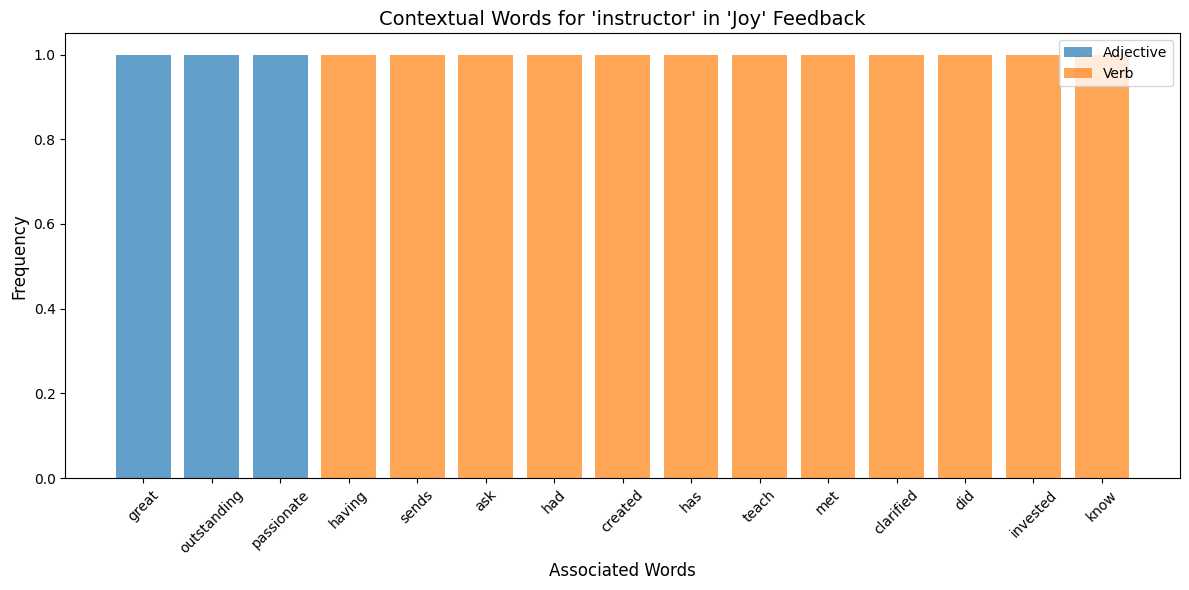

Context bar chart plotted for 'instructor' in 'joy'.


2025-04-01 14:58:32,496 [INFO] Context bar chart plotted for 'instructor' in 'joy'.


Analyzing top 5 nouns/pronouns across all emotions...


2025-04-01 14:58:32,497 [INFO] Analyzing top 5 nouns/pronouns across all emotions...


Extracting top nouns/pronouns for emotion 'anger'...


2025-04-01 14:58:32,497 [INFO] Extracting top nouns/pronouns for emotion 'anger'...


Top 5 nouns/pronouns for 'anger': ['assignments', 'students', 'everything', 'nothing', 'week']


2025-04-01 14:58:32,696 [INFO] Top 5 nouns/pronouns for 'anger': ['assignments', 'students', 'everything', 'nothing', 'week']


Analyzing context for 'assignments' in emotion 'anger'...


2025-04-01 14:58:32,697 [INFO] Analyzing context for 'assignments' in emotion 'anger'...


Context analysis completed for 'assignments' in 'anger'. Found 2 adjectives and 7 verbs.


2025-04-01 14:58:32,890 [INFO] Context analysis completed for 'assignments' in 'anger'. Found 2 adjectives and 7 verbs.


Analyzing context for 'students' in emotion 'anger'...


2025-04-01 14:58:32,891 [INFO] Analyzing context for 'students' in emotion 'anger'...


Context analysis completed for 'students' in 'anger'. Found 1 adjectives and 9 verbs.


2025-04-01 14:58:33,083 [INFO] Context analysis completed for 'students' in 'anger'. Found 1 adjectives and 9 verbs.


Analyzing context for 'everything' in emotion 'anger'...


2025-04-01 14:58:33,083 [INFO] Analyzing context for 'everything' in emotion 'anger'...


Context analysis completed for 'everything' in 'anger'. Found 0 adjectives and 3 verbs.


2025-04-01 14:58:33,276 [INFO] Context analysis completed for 'everything' in 'anger'. Found 0 adjectives and 3 verbs.


Analyzing context for 'nothing' in emotion 'anger'...


2025-04-01 14:58:33,276 [INFO] Analyzing context for 'nothing' in emotion 'anger'...


Context analysis completed for 'nothing' in 'anger'. Found 0 adjectives and 2 verbs.


2025-04-01 14:58:33,466 [INFO] Context analysis completed for 'nothing' in 'anger'. Found 0 adjectives and 2 verbs.


Analyzing context for 'week' in emotion 'anger'...


2025-04-01 14:58:33,466 [INFO] Analyzing context for 'week' in emotion 'anger'...


Context analysis completed for 'week' in 'anger'. Found 0 adjectives and 1 verbs.


2025-04-01 14:58:33,656 [INFO] Context analysis completed for 'week' in 'anger'. Found 0 adjectives and 1 verbs.


Extracting top nouns/pronouns for emotion 'disgust'...


2025-04-01 14:58:33,656 [INFO] Extracting top nouns/pronouns for emotion 'disgust'...


Top 5 nouns/pronouns for 'disgust': ['nothing', 'semester', 'lot', 'computer', 'students']


2025-04-01 14:58:33,696 [INFO] Top 5 nouns/pronouns for 'disgust': ['nothing', 'semester', 'lot', 'computer', 'students']


Analyzing context for 'nothing' in emotion 'disgust'...


2025-04-01 14:58:33,697 [INFO] Analyzing context for 'nothing' in emotion 'disgust'...


Context analysis completed for 'nothing' in 'disgust'. Found 0 adjectives and 2 verbs.


2025-04-01 14:58:33,743 [INFO] Context analysis completed for 'nothing' in 'disgust'. Found 0 adjectives and 2 verbs.


Analyzing context for 'semester' in emotion 'disgust'...


2025-04-01 14:58:33,743 [INFO] Analyzing context for 'semester' in emotion 'disgust'...


Context analysis completed for 'semester' in 'disgust'. Found 0 adjectives and 1 verbs.


2025-04-01 14:58:33,788 [INFO] Context analysis completed for 'semester' in 'disgust'. Found 0 adjectives and 1 verbs.


Analyzing context for 'lot' in emotion 'disgust'...


2025-04-01 14:58:33,789 [INFO] Analyzing context for 'lot' in emotion 'disgust'...


Context analysis completed for 'lot' in 'disgust'. Found 0 adjectives and 2 verbs.


2025-04-01 14:58:33,834 [INFO] Context analysis completed for 'lot' in 'disgust'. Found 0 adjectives and 2 verbs.


Analyzing context for 'computer' in emotion 'disgust'...


2025-04-01 14:58:33,835 [INFO] Analyzing context for 'computer' in emotion 'disgust'...


Context analysis completed for 'computer' in 'disgust'. Found 0 adjectives and 0 verbs.


2025-04-01 14:58:33,881 [INFO] Context analysis completed for 'computer' in 'disgust'. Found 0 adjectives and 0 verbs.


Analyzing context for 'students' in emotion 'disgust'...


2025-04-01 14:58:33,882 [INFO] Analyzing context for 'students' in emotion 'disgust'...


Context analysis completed for 'students' in 'disgust'. Found 1 adjectives and 2 verbs.


2025-04-01 14:58:33,929 [INFO] Context analysis completed for 'students' in 'disgust'. Found 1 adjectives and 2 verbs.


Extracting top nouns/pronouns for emotion 'fear'...


2025-04-01 14:58:33,930 [INFO] Extracting top nouns/pronouns for emotion 'fear'...


Top 5 nouns/pronouns for 'fear': ['attempt', 'test', 'simnet', 'system', 'management']


2025-04-01 14:58:33,950 [INFO] Top 5 nouns/pronouns for 'fear': ['attempt', 'test', 'simnet', 'system', 'management']


Analyzing context for 'attempt' in emotion 'fear'...


2025-04-01 14:58:33,950 [INFO] Analyzing context for 'attempt' in emotion 'fear'...


Context analysis completed for 'attempt' in 'fear'. Found 1 adjectives and 1 verbs.


2025-04-01 14:58:33,979 [INFO] Context analysis completed for 'attempt' in 'fear'. Found 1 adjectives and 1 verbs.


Analyzing context for 'test' in emotion 'fear'...


2025-04-01 14:58:33,979 [INFO] Analyzing context for 'test' in emotion 'fear'...


Context analysis completed for 'test' in 'fear'. Found 0 adjectives and 1 verbs.


2025-04-01 14:58:34,003 [INFO] Context analysis completed for 'test' in 'fear'. Found 0 adjectives and 1 verbs.


Analyzing context for 'simnet' in emotion 'fear'...


2025-04-01 14:58:34,004 [INFO] Analyzing context for 'simnet' in emotion 'fear'...


Context analysis completed for 'simnet' in 'fear'. Found 0 adjectives and 1 verbs.


2025-04-01 14:58:34,028 [INFO] Context analysis completed for 'simnet' in 'fear'. Found 0 adjectives and 1 verbs.


Analyzing context for 'system' in emotion 'fear'...


2025-04-01 14:58:34,028 [INFO] Analyzing context for 'system' in emotion 'fear'...


Context analysis completed for 'system' in 'fear'. Found 0 adjectives and 0 verbs.


2025-04-01 14:58:34,051 [INFO] Context analysis completed for 'system' in 'fear'. Found 0 adjectives and 0 verbs.


Analyzing context for 'management' in emotion 'fear'...


2025-04-01 14:58:34,052 [INFO] Analyzing context for 'management' in emotion 'fear'...


Context analysis completed for 'management' in 'fear'. Found 1 adjectives and 1 verbs.


2025-04-01 14:58:34,074 [INFO] Context analysis completed for 'management' in 'fear'. Found 1 adjectives and 1 verbs.


Extracting top nouns/pronouns for emotion 'joy'...


2025-04-01 14:58:34,075 [INFO] Extracting top nouns/pronouns for emotion 'joy'...


Top 5 nouns/pronouns for 'joy': ['assignments', 'instructor', 'week', 'lot', 'everything']


2025-04-01 14:58:34,865 [INFO] Top 5 nouns/pronouns for 'joy': ['assignments', 'instructor', 'week', 'lot', 'everything']


Analyzing context for 'assignments' in emotion 'joy'...


2025-04-01 14:58:34,866 [INFO] Analyzing context for 'assignments' in emotion 'joy'...


Context analysis completed for 'assignments' in 'joy'. Found 9 adjectives and 23 verbs.


2025-04-01 14:58:35,711 [INFO] Context analysis completed for 'assignments' in 'joy'. Found 9 adjectives and 23 verbs.


Analyzing context for 'instructor' in emotion 'joy'...


2025-04-01 14:58:35,712 [INFO] Analyzing context for 'instructor' in emotion 'joy'...


Context analysis completed for 'instructor' in 'joy'. Found 3 adjectives and 12 verbs.


2025-04-01 14:58:36,560 [INFO] Context analysis completed for 'instructor' in 'joy'. Found 3 adjectives and 12 verbs.


Analyzing context for 'week' in emotion 'joy'...


2025-04-01 14:58:36,561 [INFO] Analyzing context for 'week' in emotion 'joy'...


Context analysis completed for 'week' in 'joy'. Found 2 adjectives and 3 verbs.


2025-04-01 14:58:37,409 [INFO] Context analysis completed for 'week' in 'joy'. Found 2 adjectives and 3 verbs.


Analyzing context for 'lot' in emotion 'joy'...


2025-04-01 14:58:37,409 [INFO] Analyzing context for 'lot' in emotion 'joy'...


Context analysis completed for 'lot' in 'joy'. Found 0 adjectives and 12 verbs.


2025-04-01 14:58:38,259 [INFO] Context analysis completed for 'lot' in 'joy'. Found 0 adjectives and 12 verbs.


Analyzing context for 'everything' in emotion 'joy'...


2025-04-01 14:58:38,260 [INFO] Analyzing context for 'everything' in emotion 'joy'...


Context analysis completed for 'everything' in 'joy'. Found 2 adjectives and 12 verbs.


2025-04-01 14:58:39,118 [INFO] Context analysis completed for 'everything' in 'joy'. Found 2 adjectives and 12 verbs.


Extracting top nouns/pronouns for emotion 'neutral'...


2025-04-01 14:58:39,119 [INFO] Extracting top nouns/pronouns for emotion 'neutral'...


Top 5 nouns/pronouns for 'neutral': ['assignments', 'instructor', 'week', 'students', 'nothing']


2025-04-01 14:58:42,787 [INFO] Top 5 nouns/pronouns for 'neutral': ['assignments', 'instructor', 'week', 'students', 'nothing']


Analyzing context for 'assignments' in emotion 'neutral'...


2025-04-01 14:58:42,788 [INFO] Analyzing context for 'assignments' in emotion 'neutral'...


Context analysis completed for 'assignments' in 'neutral'. Found 22 adjectives and 53 verbs.


2025-04-01 14:58:46,683 [INFO] Context analysis completed for 'assignments' in 'neutral'. Found 22 adjectives and 53 verbs.


Analyzing context for 'instructor' in emotion 'neutral'...


2025-04-01 14:58:46,684 [INFO] Analyzing context for 'instructor' in emotion 'neutral'...


Context analysis completed for 'instructor' in 'neutral'. Found 7 adjectives and 39 verbs.


2025-04-01 14:58:50,560 [INFO] Context analysis completed for 'instructor' in 'neutral'. Found 7 adjectives and 39 verbs.


Analyzing context for 'week' in emotion 'neutral'...


2025-04-01 14:58:50,560 [INFO] Analyzing context for 'week' in emotion 'neutral'...


Context analysis completed for 'week' in 'neutral'. Found 9 adjectives and 31 verbs.


2025-04-01 14:58:54,463 [INFO] Context analysis completed for 'week' in 'neutral'. Found 9 adjectives and 31 verbs.


Analyzing context for 'students' in emotion 'neutral'...


2025-04-01 14:58:54,464 [INFO] Analyzing context for 'students' in emotion 'neutral'...


Context analysis completed for 'students' in 'neutral'. Found 8 adjectives and 40 verbs.


2025-04-01 14:58:58,343 [INFO] Context analysis completed for 'students' in 'neutral'. Found 8 adjectives and 40 verbs.


Analyzing context for 'nothing' in emotion 'neutral'...


2025-04-01 14:58:58,344 [INFO] Analyzing context for 'nothing' in emotion 'neutral'...


Context analysis completed for 'nothing' in 'neutral'. Found 2 adjectives and 30 verbs.


2025-04-01 14:59:02,216 [INFO] Context analysis completed for 'nothing' in 'neutral'. Found 2 adjectives and 30 verbs.


Extracting top nouns/pronouns for emotion 'sadness'...


2025-04-01 14:59:02,216 [INFO] Extracting top nouns/pronouns for emotion 'sadness'...


Top 5 nouns/pronouns for 'sadness': ['assignments', 'instructor', 'students', 'week', 'simnet']


2025-04-01 14:59:02,996 [INFO] Top 5 nouns/pronouns for 'sadness': ['assignments', 'instructor', 'students', 'week', 'simnet']


Analyzing context for 'assignments' in emotion 'sadness'...


2025-04-01 14:59:02,997 [INFO] Analyzing context for 'assignments' in emotion 'sadness'...


Context analysis completed for 'assignments' in 'sadness'. Found 10 adjectives and 18 verbs.


2025-04-01 14:59:03,848 [INFO] Context analysis completed for 'assignments' in 'sadness'. Found 10 adjectives and 18 verbs.


Analyzing context for 'instructor' in emotion 'sadness'...


2025-04-01 14:59:03,849 [INFO] Analyzing context for 'instructor' in emotion 'sadness'...


Context analysis completed for 'instructor' in 'sadness'. Found 1 adjectives and 12 verbs.


2025-04-01 14:59:04,705 [INFO] Context analysis completed for 'instructor' in 'sadness'. Found 1 adjectives and 12 verbs.


Analyzing context for 'students' in emotion 'sadness'...


2025-04-01 14:59:04,705 [INFO] Analyzing context for 'students' in emotion 'sadness'...


Context analysis completed for 'students' in 'sadness'. Found 1 adjectives and 12 verbs.


2025-04-01 14:59:05,567 [INFO] Context analysis completed for 'students' in 'sadness'. Found 1 adjectives and 12 verbs.


Analyzing context for 'week' in emotion 'sadness'...


2025-04-01 14:59:05,568 [INFO] Analyzing context for 'week' in emotion 'sadness'...


Context analysis completed for 'week' in 'sadness'. Found 2 adjectives and 2 verbs.


2025-04-01 14:59:06,422 [INFO] Context analysis completed for 'week' in 'sadness'. Found 2 adjectives and 2 verbs.


Analyzing context for 'simnet' in emotion 'sadness'...


2025-04-01 14:59:06,423 [INFO] Analyzing context for 'simnet' in emotion 'sadness'...


Context analysis completed for 'simnet' in 'sadness'. Found 0 adjectives and 14 verbs.


2025-04-01 14:59:07,378 [INFO] Context analysis completed for 'simnet' in 'sadness'. Found 0 adjectives and 14 verbs.


Extracting top nouns/pronouns for emotion 'surprise'...


2025-04-01 14:59:07,379 [INFO] Extracting top nouns/pronouns for emotion 'surprise'...


Top 5 nouns/pronouns for 'surprise': ['assignments', 'things', 'quiz', 'instructor', 'bit']


2025-04-01 14:59:07,542 [INFO] Top 5 nouns/pronouns for 'surprise': ['assignments', 'things', 'quiz', 'instructor', 'bit']


Analyzing context for 'assignments' in emotion 'surprise'...


2025-04-01 14:59:07,544 [INFO] Analyzing context for 'assignments' in emotion 'surprise'...


Context analysis completed for 'assignments' in 'surprise'. Found 4 adjectives and 4 verbs.


2025-04-01 14:59:07,738 [INFO] Context analysis completed for 'assignments' in 'surprise'. Found 4 adjectives and 4 verbs.


Analyzing context for 'things' in emotion 'surprise'...


2025-04-01 14:59:07,739 [INFO] Analyzing context for 'things' in emotion 'surprise'...


Context analysis completed for 'things' in 'surprise'. Found 2 adjectives and 6 verbs.


2025-04-01 14:59:07,936 [INFO] Context analysis completed for 'things' in 'surprise'. Found 2 adjectives and 6 verbs.


Analyzing context for 'quiz' in emotion 'surprise'...


2025-04-01 14:59:07,937 [INFO] Analyzing context for 'quiz' in emotion 'surprise'...


Context analysis completed for 'quiz' in 'surprise'. Found 0 adjectives and 1 verbs.


2025-04-01 14:59:08,129 [INFO] Context analysis completed for 'quiz' in 'surprise'. Found 0 adjectives and 1 verbs.


Analyzing context for 'instructor' in emotion 'surprise'...


2025-04-01 14:59:08,129 [INFO] Analyzing context for 'instructor' in emotion 'surprise'...


Context analysis completed for 'instructor' in 'surprise'. Found 1 adjectives and 3 verbs.


2025-04-01 14:59:08,342 [INFO] Context analysis completed for 'instructor' in 'surprise'. Found 1 adjectives and 3 verbs.


Analyzing context for 'bit' in emotion 'surprise'...


2025-04-01 14:59:08,343 [INFO] Analyzing context for 'bit' in emotion 'surprise'...


Context analysis completed for 'bit' in 'surprise'. Found 1 adjectives and 1 verbs.


2025-04-01 14:59:08,534 [INFO] Context analysis completed for 'bit' in 'surprise'. Found 1 adjectives and 1 verbs.


Analysis of top nouns/pronouns completed.


2025-04-01 14:59:08,535 [INFO] Analysis of top nouns/pronouns completed.


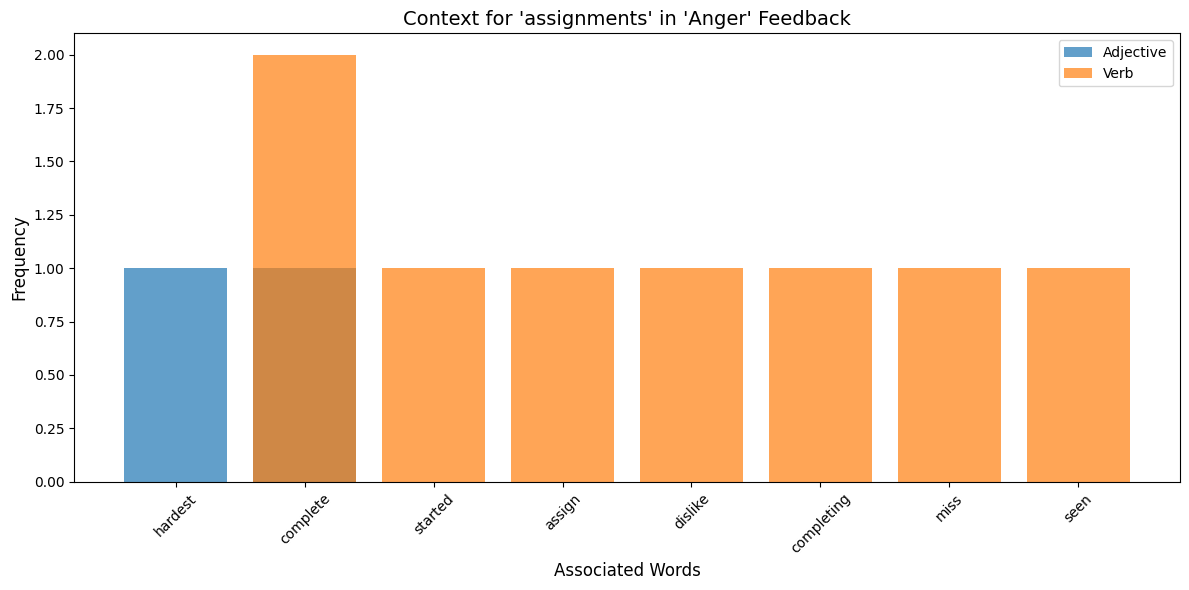

Plotted context for 'assignments' in 'anger'.


2025-04-01 14:59:08,595 [INFO] Plotted context for 'assignments' in 'anger'.


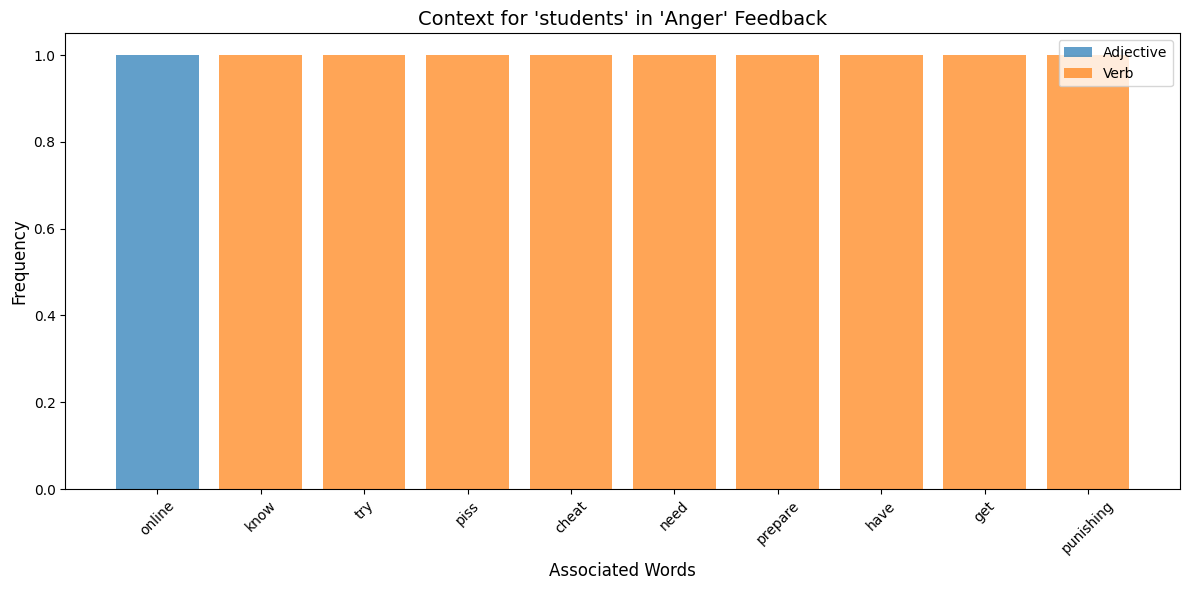

Plotted context for 'students' in 'anger'.


2025-04-01 14:59:08,659 [INFO] Plotted context for 'students' in 'anger'.


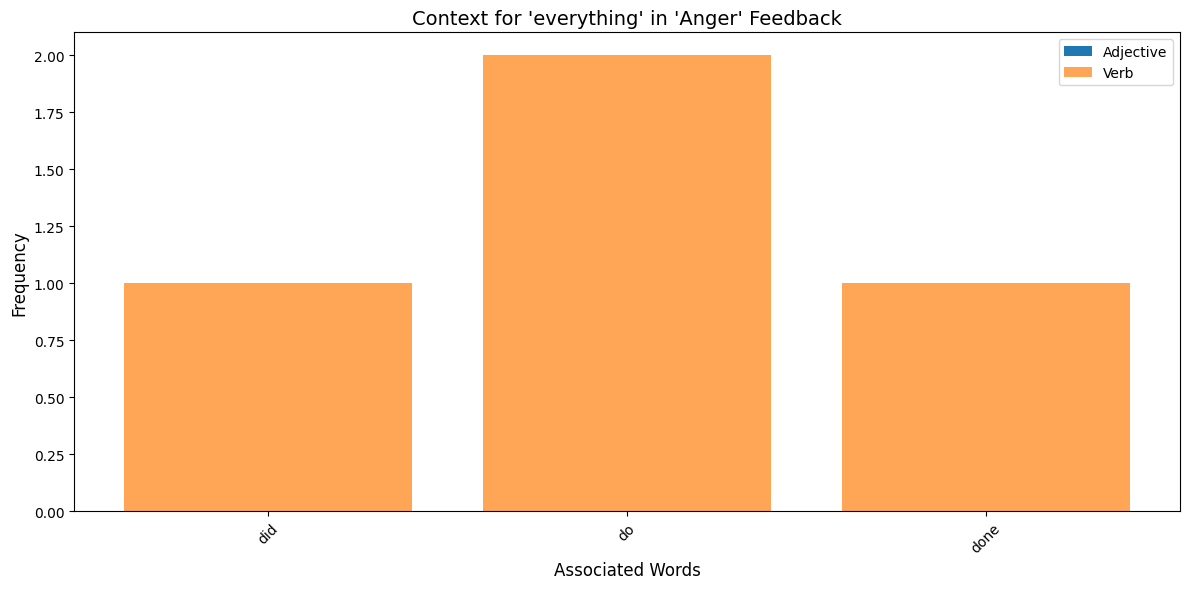

Plotted context for 'everything' in 'anger'.


2025-04-01 14:59:08,710 [INFO] Plotted context for 'everything' in 'anger'.


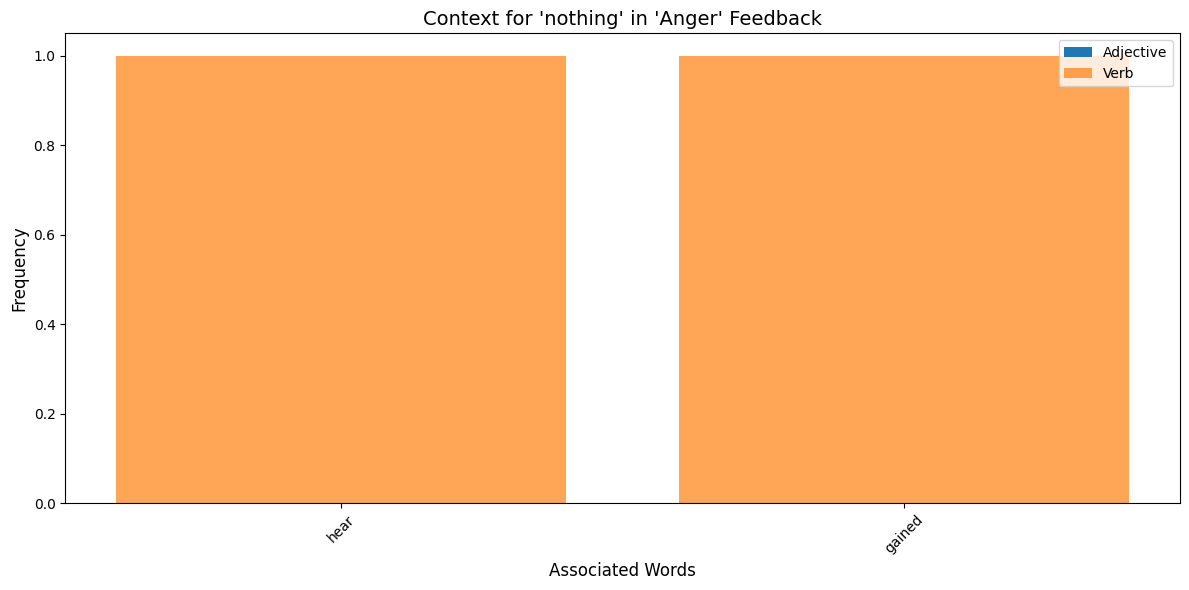

Plotted context for 'nothing' in 'anger'.


2025-04-01 14:59:08,758 [INFO] Plotted context for 'nothing' in 'anger'.


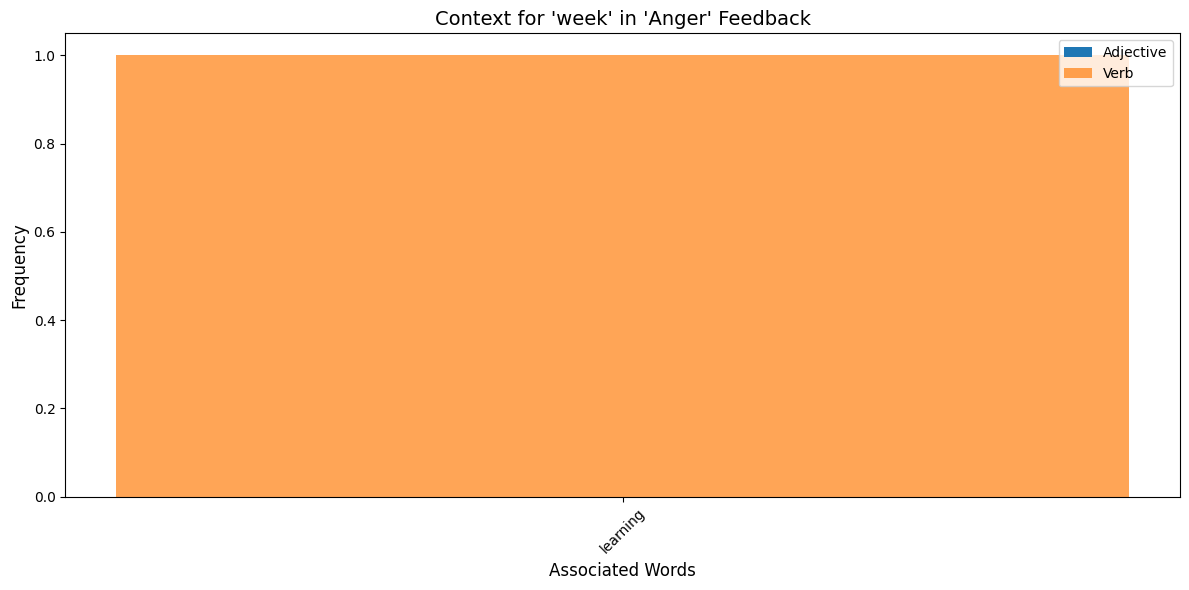

Plotted context for 'week' in 'anger'.


2025-04-01 14:59:08,808 [INFO] Plotted context for 'week' in 'anger'.


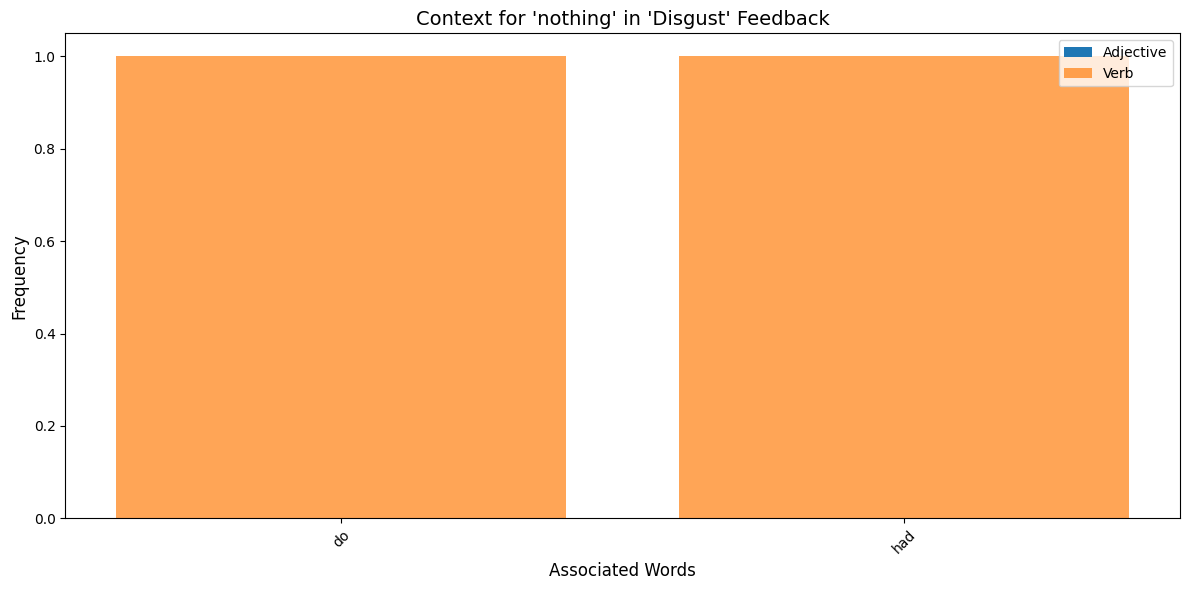

Plotted context for 'nothing' in 'disgust'.


2025-04-01 14:59:08,854 [INFO] Plotted context for 'nothing' in 'disgust'.


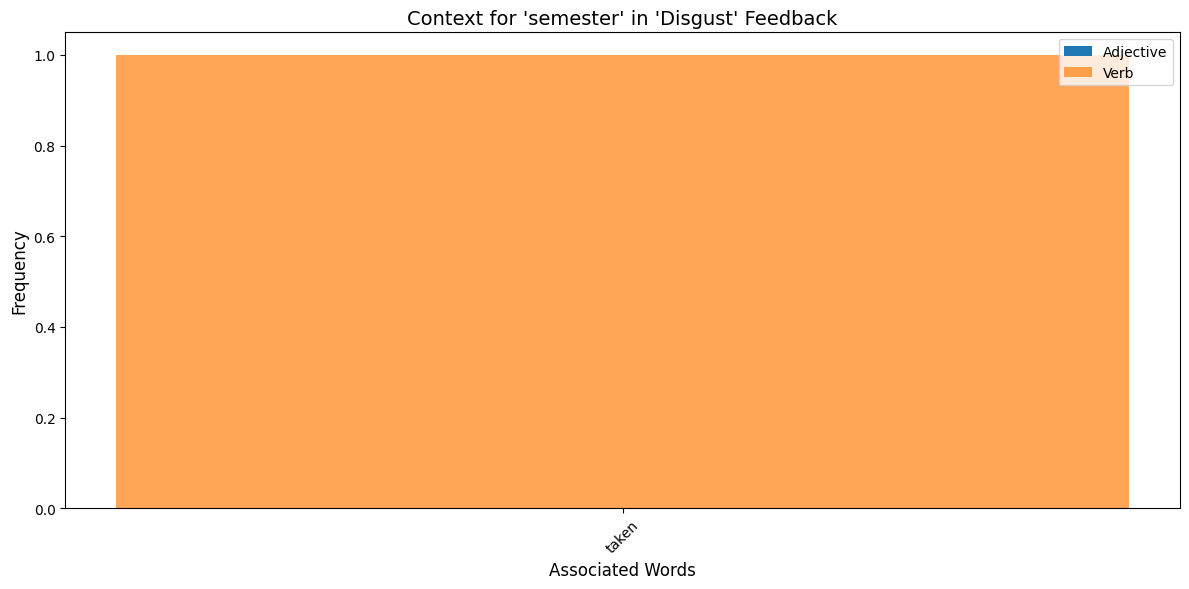

Plotted context for 'semester' in 'disgust'.


2025-04-01 14:59:08,898 [INFO] Plotted context for 'semester' in 'disgust'.


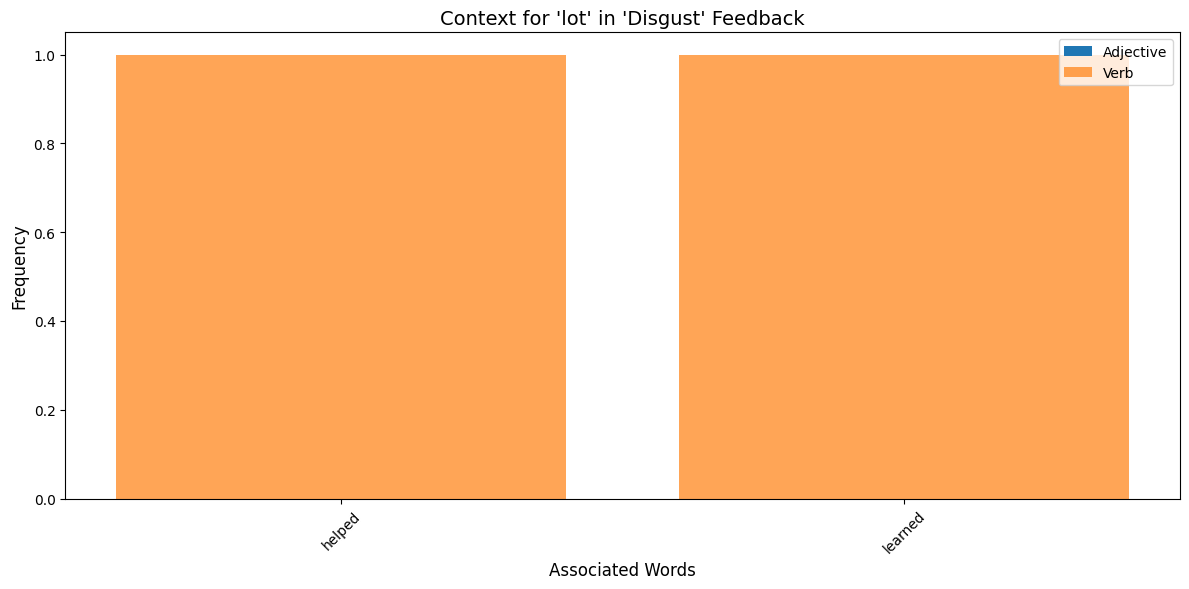

Plotted context for 'lot' in 'disgust'.


2025-04-01 14:59:08,943 [INFO] Plotted context for 'lot' in 'disgust'.


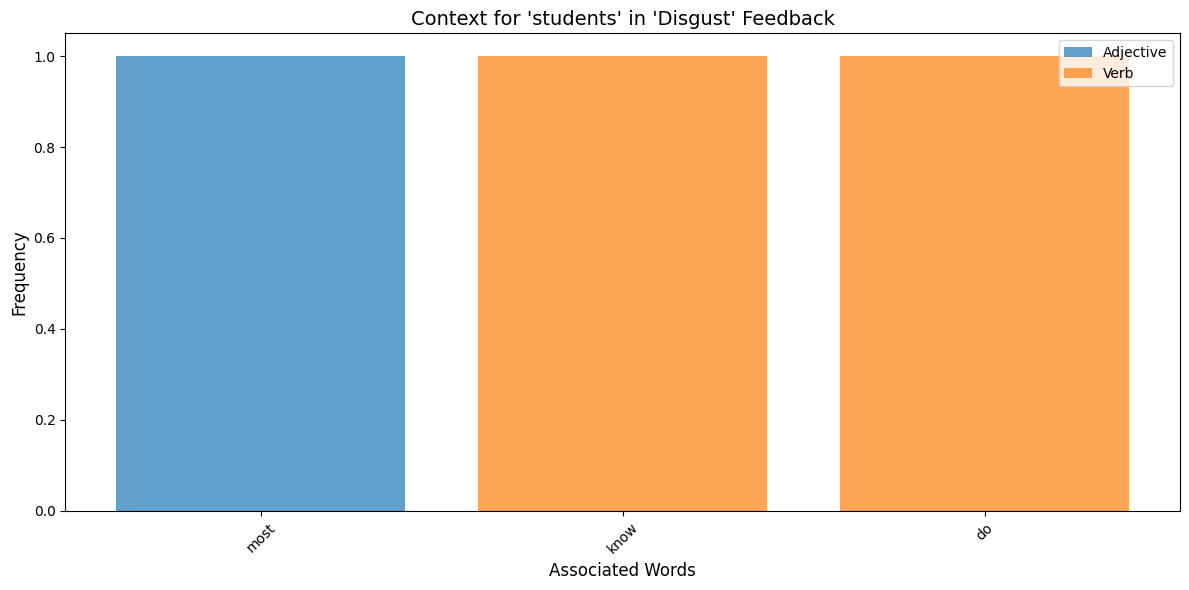

Plotted context for 'students' in 'disgust'.


2025-04-01 14:59:09,000 [INFO] Plotted context for 'students' in 'disgust'.


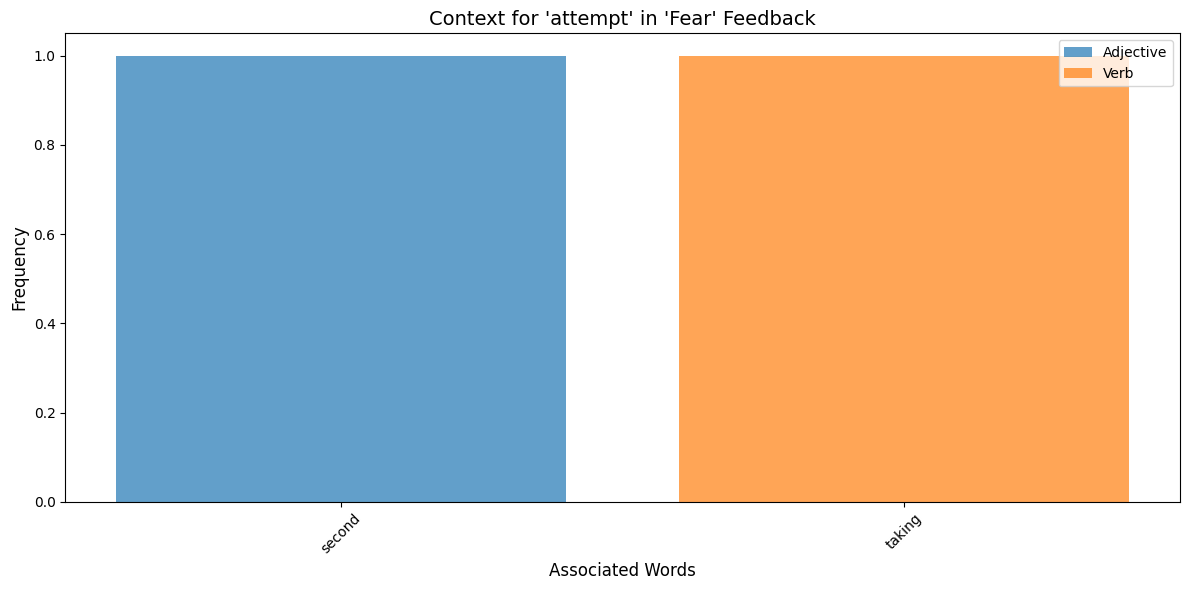

Plotted context for 'attempt' in 'fear'.


2025-04-01 14:59:09,047 [INFO] Plotted context for 'attempt' in 'fear'.


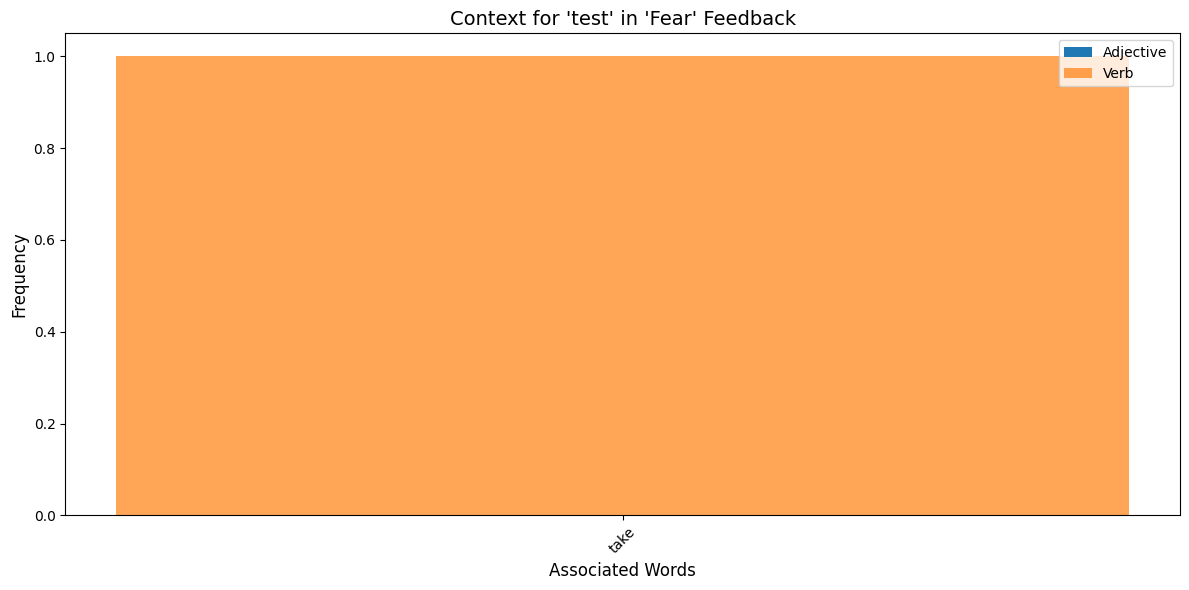

Plotted context for 'test' in 'fear'.


2025-04-01 14:59:09,091 [INFO] Plotted context for 'test' in 'fear'.


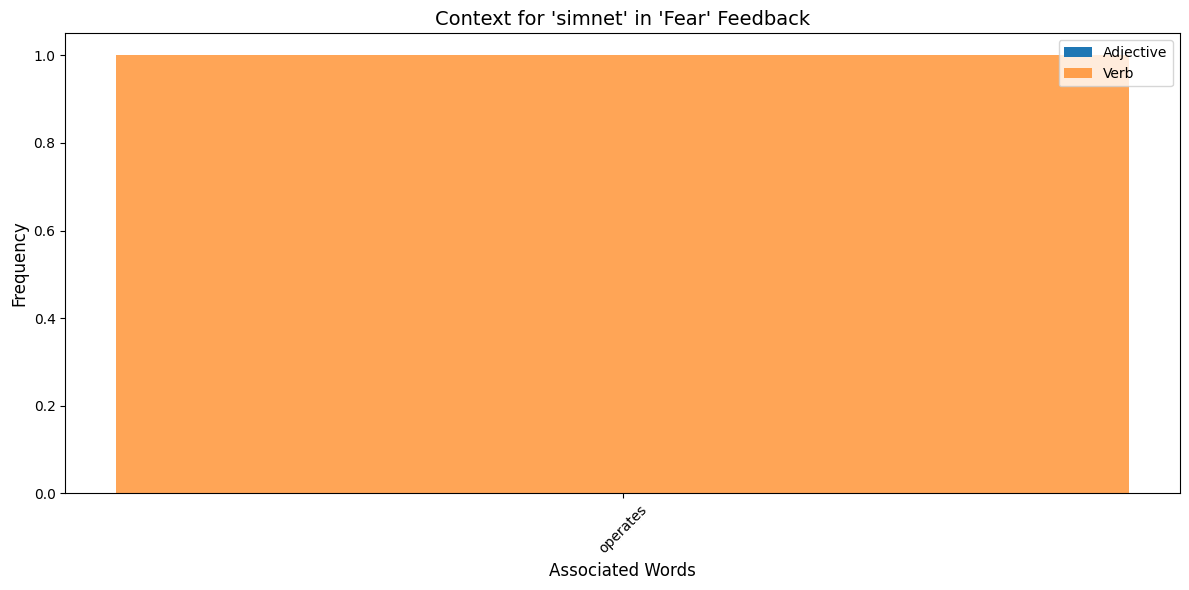

Plotted context for 'simnet' in 'fear'.


2025-04-01 14:59:09,137 [INFO] Plotted context for 'simnet' in 'fear'.


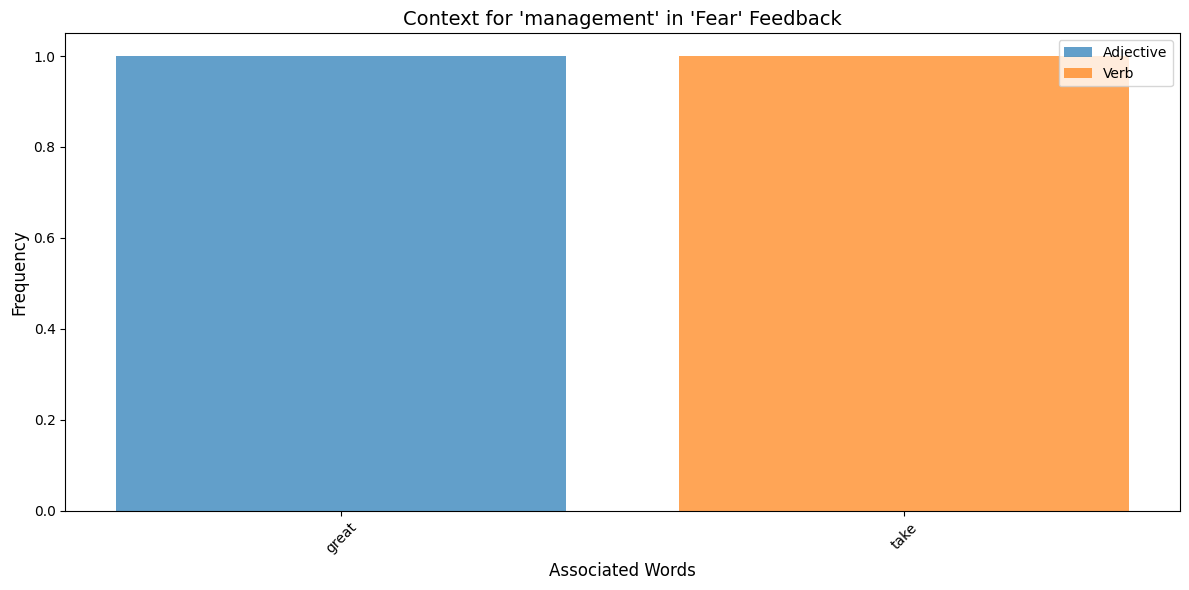

Plotted context for 'management' in 'fear'.


2025-04-01 14:59:09,183 [INFO] Plotted context for 'management' in 'fear'.


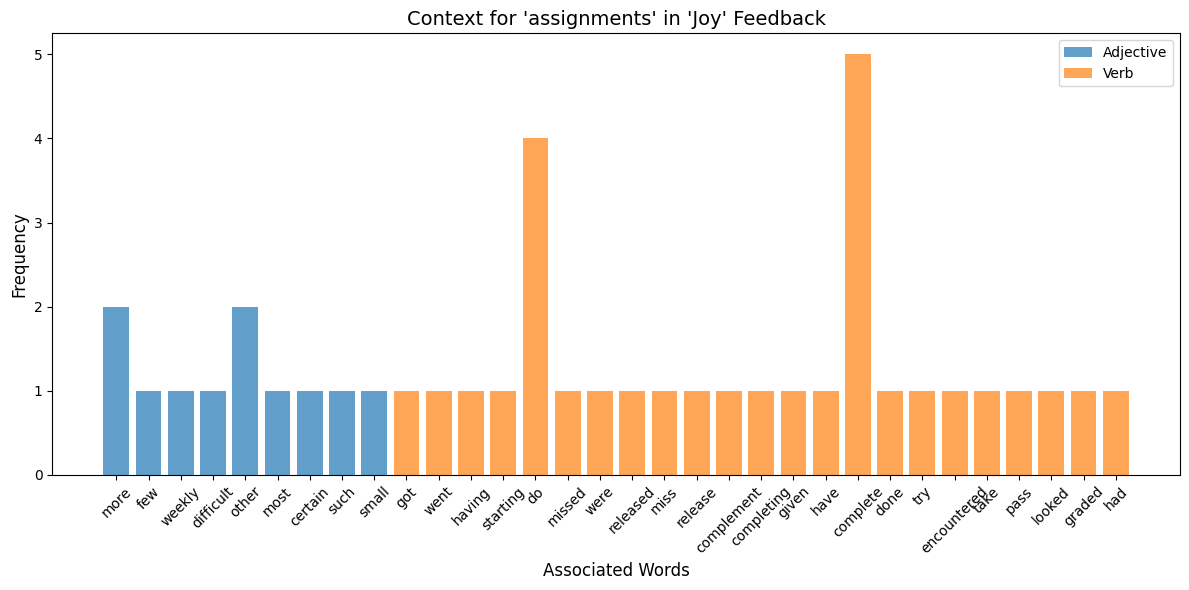

Plotted context for 'assignments' in 'joy'.


2025-04-01 14:59:09,274 [INFO] Plotted context for 'assignments' in 'joy'.


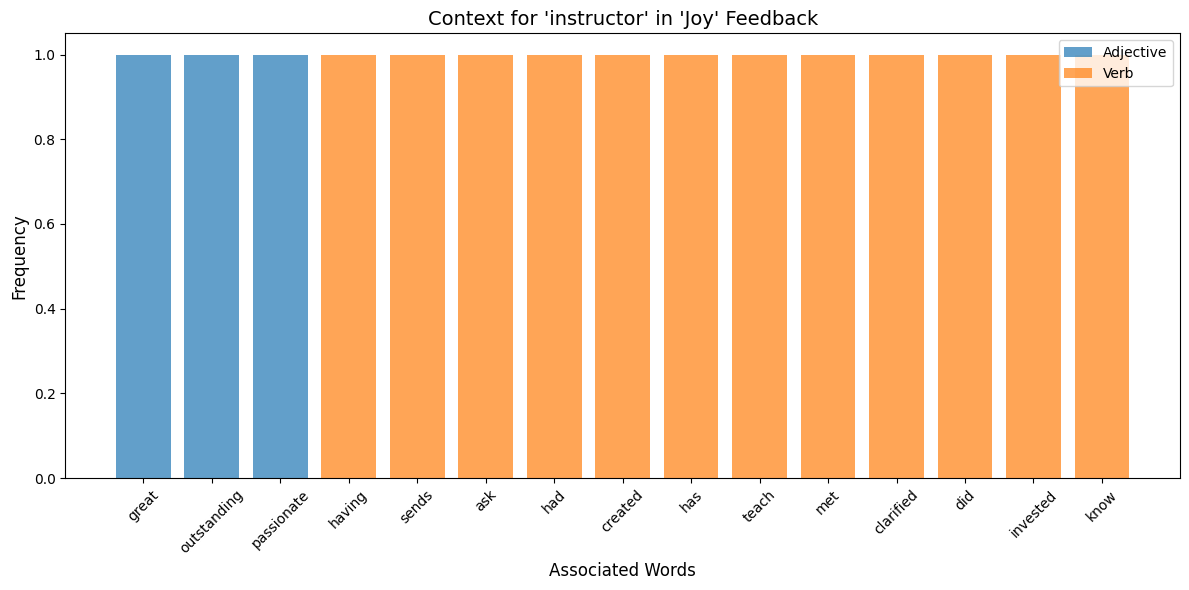

Plotted context for 'instructor' in 'joy'.


2025-04-01 14:59:09,352 [INFO] Plotted context for 'instructor' in 'joy'.


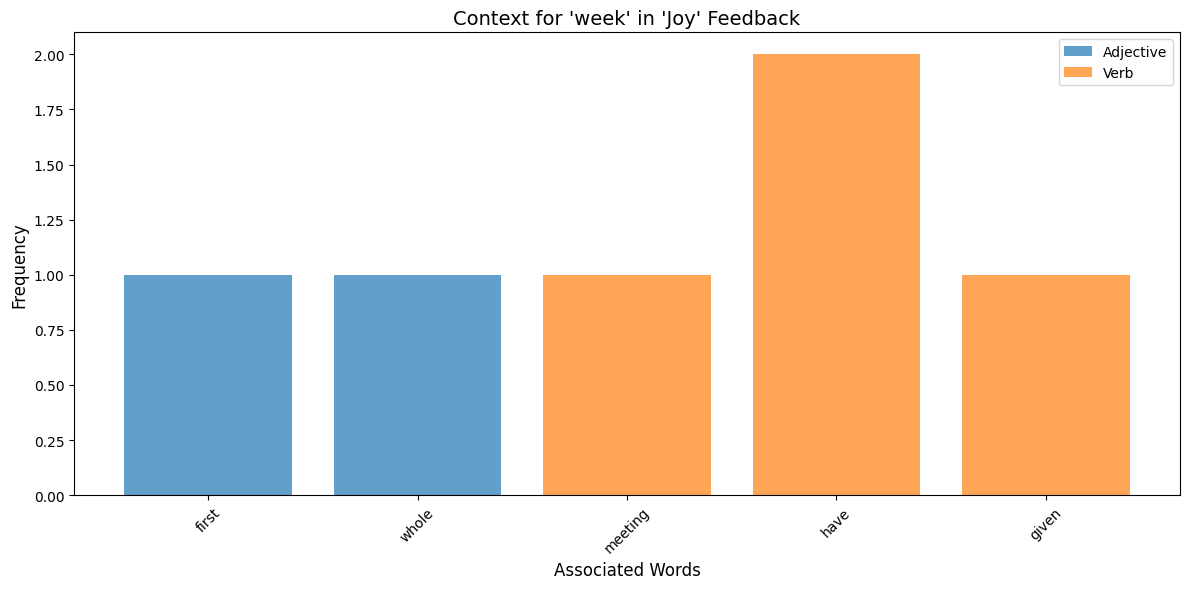

Plotted context for 'week' in 'joy'.


2025-04-01 14:59:09,405 [INFO] Plotted context for 'week' in 'joy'.


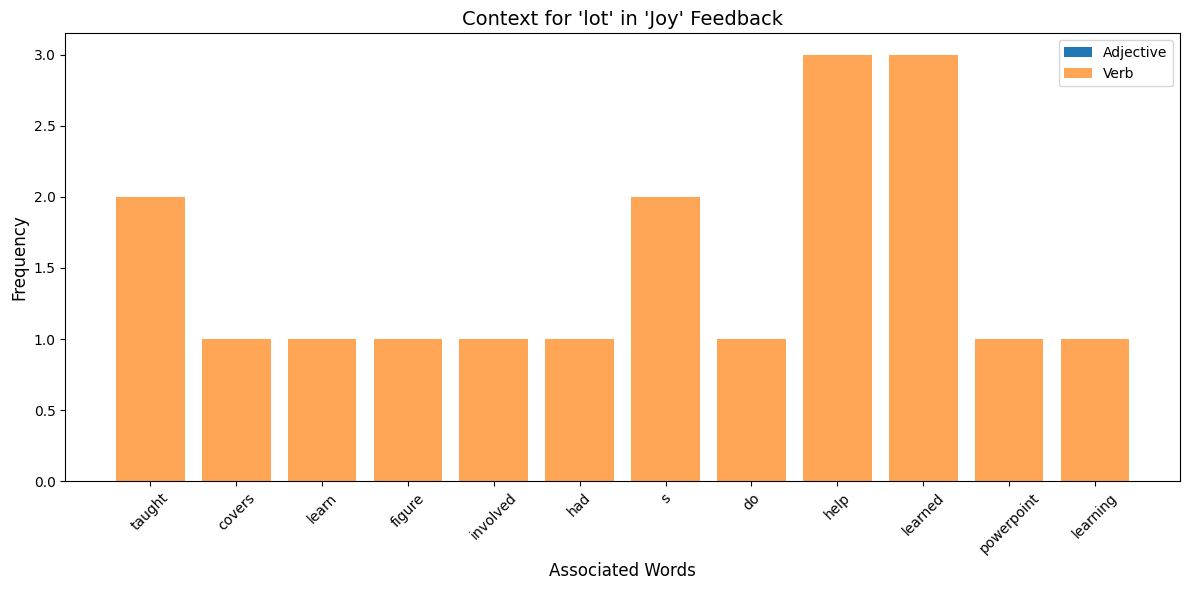

Plotted context for 'lot' in 'joy'.


2025-04-01 14:59:09,465 [INFO] Plotted context for 'lot' in 'joy'.


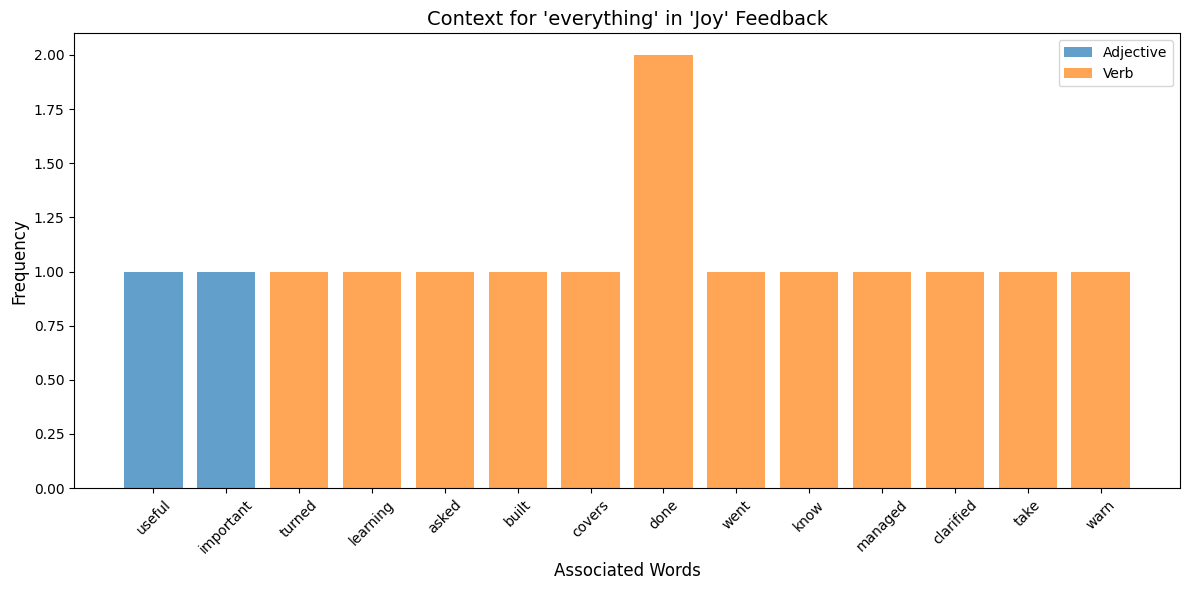

Plotted context for 'everything' in 'joy'.


2025-04-01 14:59:09,531 [INFO] Plotted context for 'everything' in 'joy'.


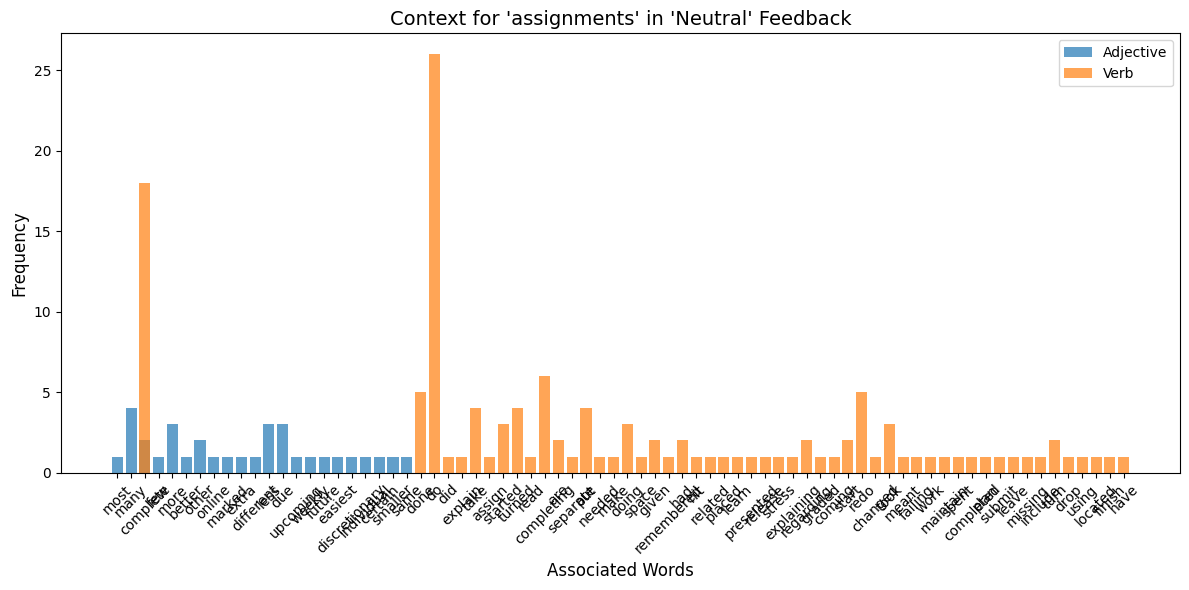

Plotted context for 'assignments' in 'neutral'.


2025-04-01 14:59:09,679 [INFO] Plotted context for 'assignments' in 'neutral'.


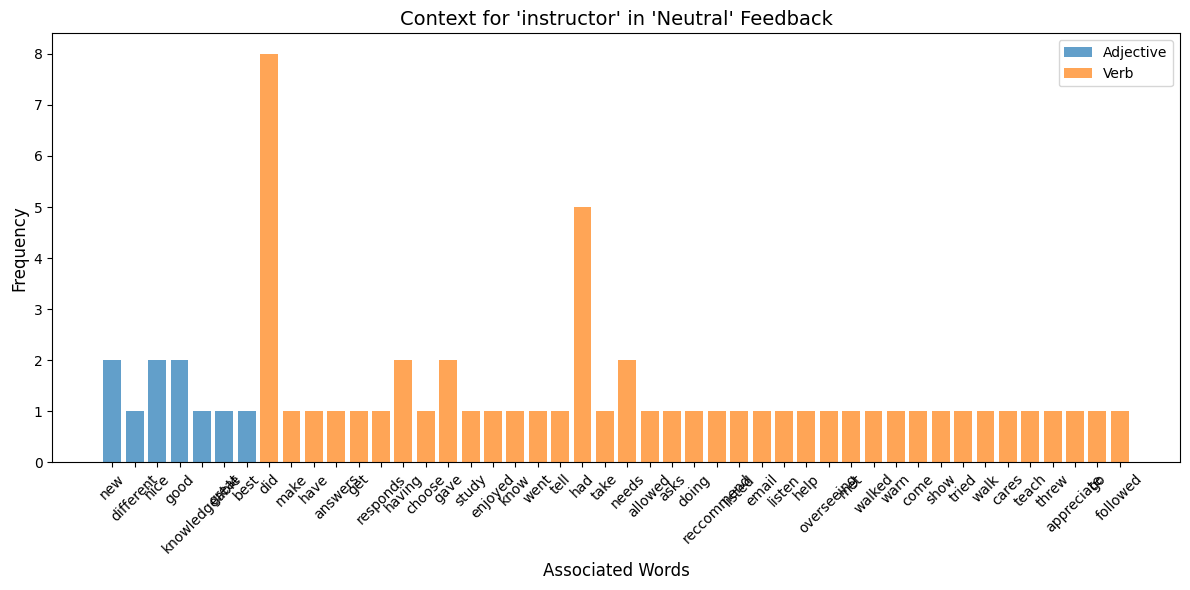

Plotted context for 'instructor' in 'neutral'.


2025-04-01 14:59:10,069 [INFO] Plotted context for 'instructor' in 'neutral'.


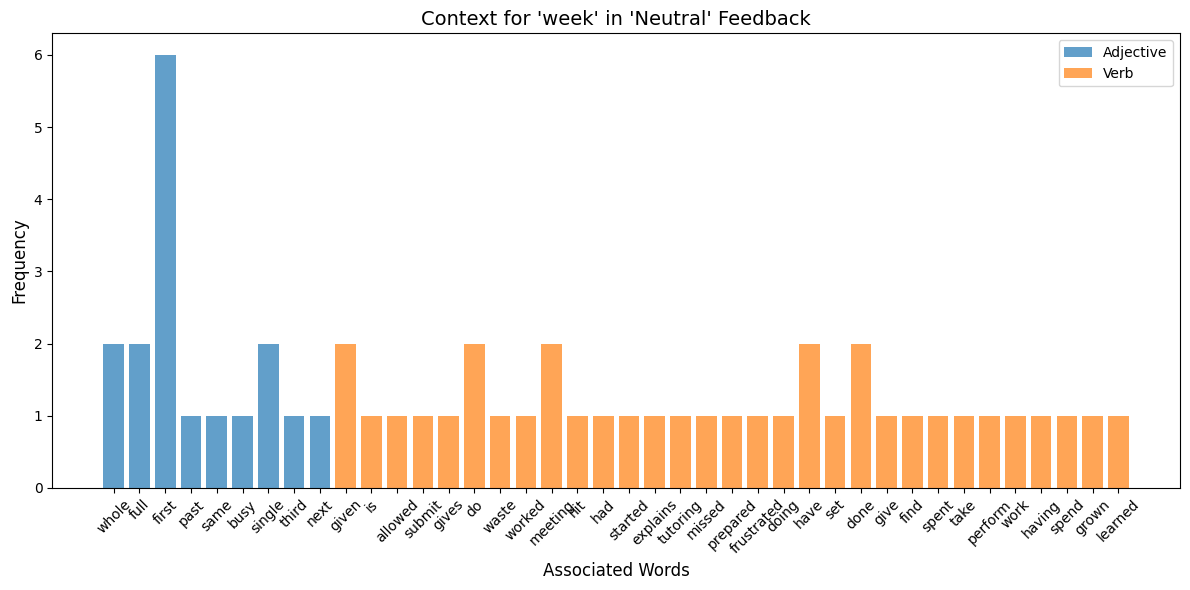

Plotted context for 'week' in 'neutral'.


2025-04-01 14:59:10,170 [INFO] Plotted context for 'week' in 'neutral'.


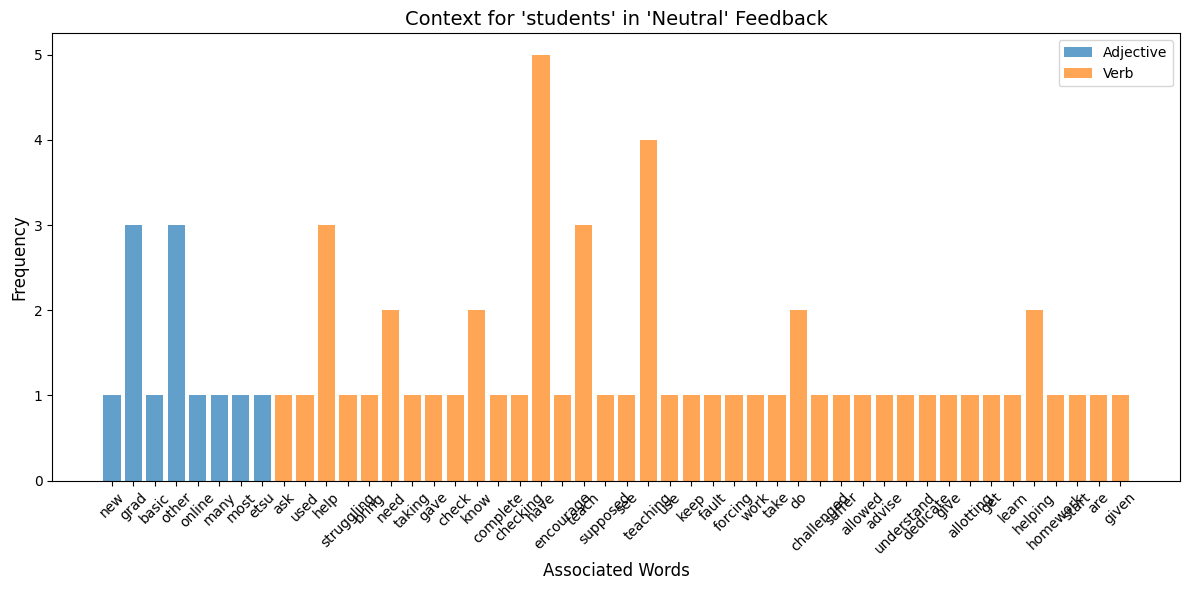

Plotted context for 'students' in 'neutral'.


2025-04-01 14:59:10,293 [INFO] Plotted context for 'students' in 'neutral'.


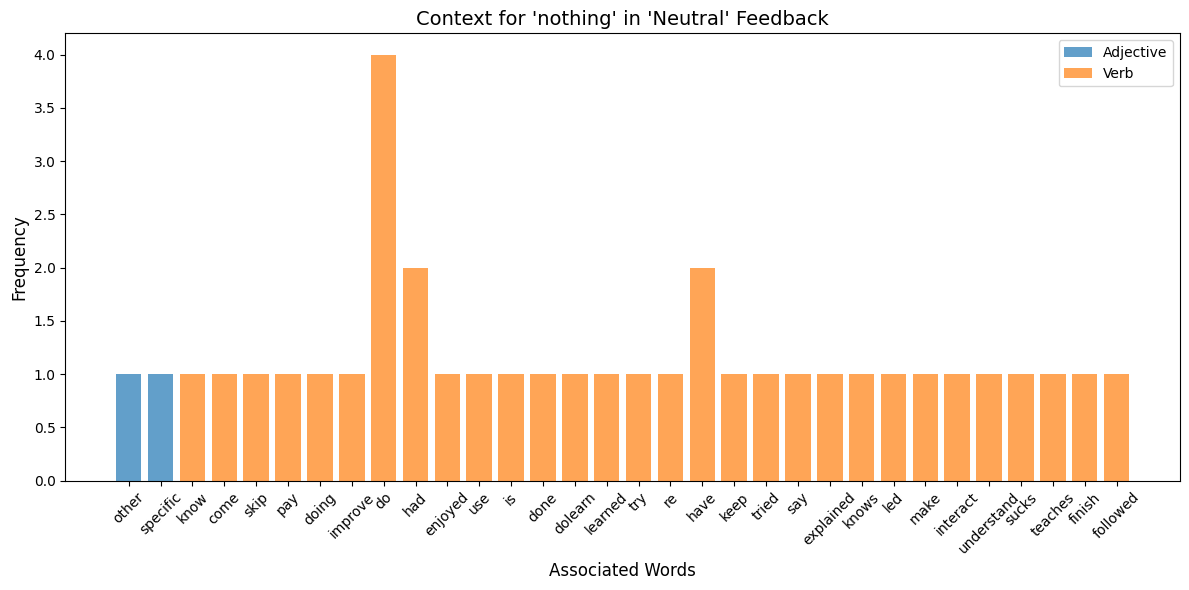

Plotted context for 'nothing' in 'neutral'.


2025-04-01 14:59:10,384 [INFO] Plotted context for 'nothing' in 'neutral'.


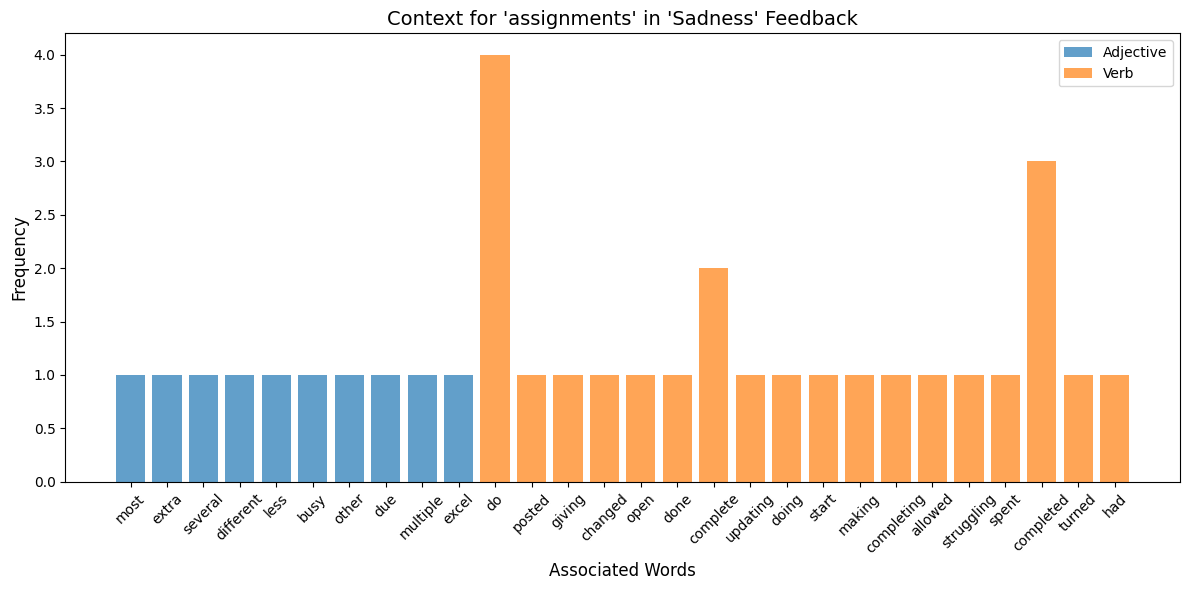

Plotted context for 'assignments' in 'sadness'.


2025-04-01 14:59:10,472 [INFO] Plotted context for 'assignments' in 'sadness'.


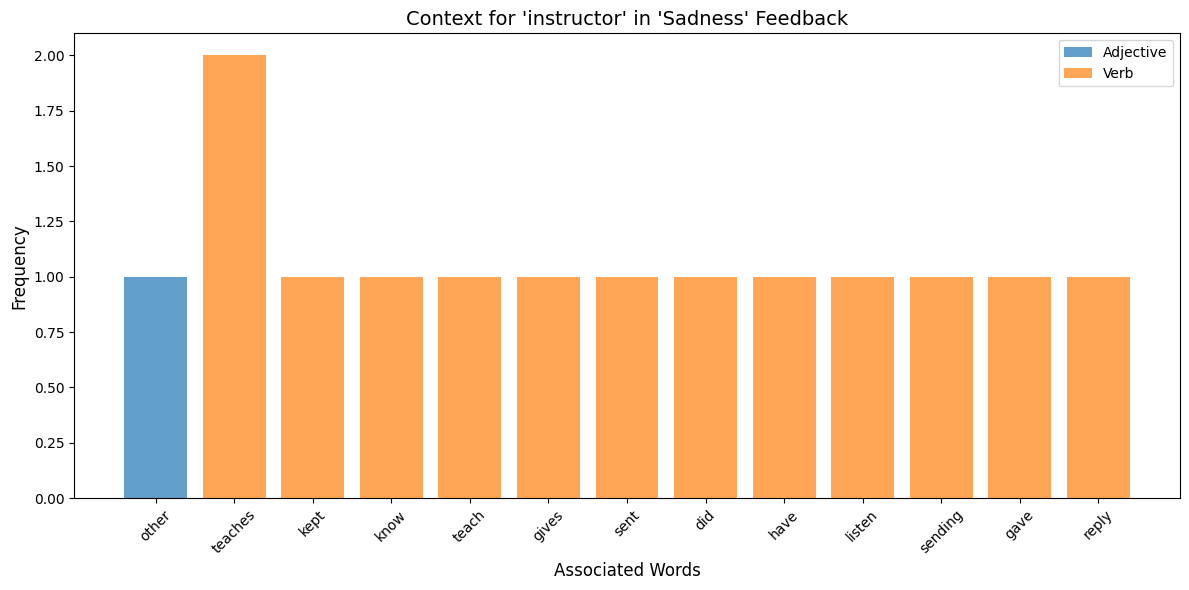

Plotted context for 'instructor' in 'sadness'.


2025-04-01 14:59:10,541 [INFO] Plotted context for 'instructor' in 'sadness'.


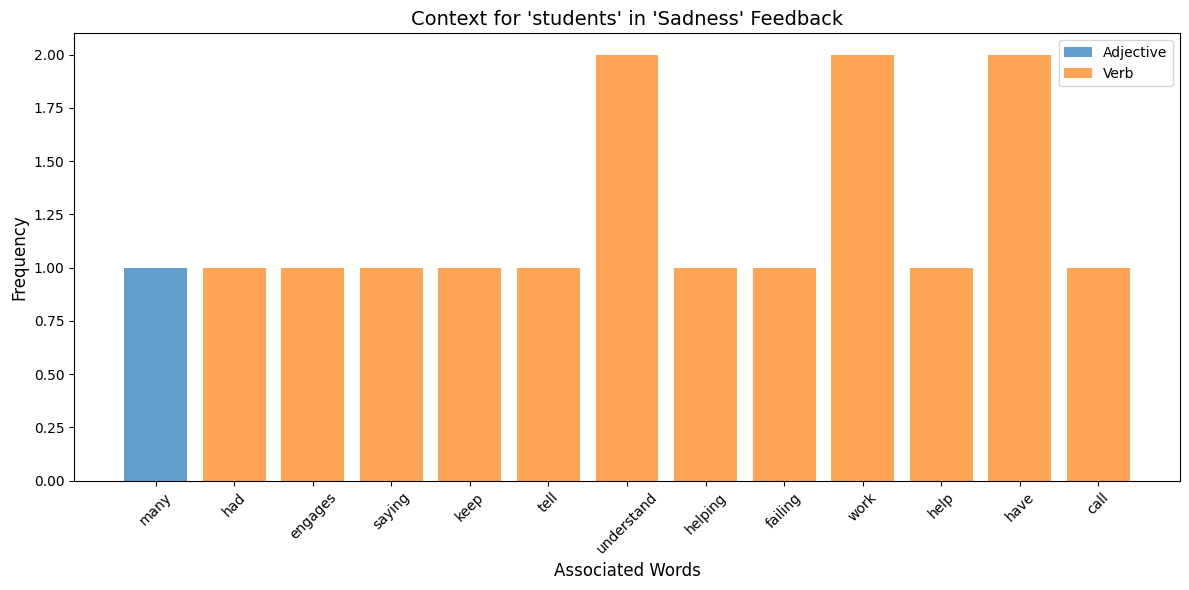

Plotted context for 'students' in 'sadness'.


2025-04-01 14:59:10,606 [INFO] Plotted context for 'students' in 'sadness'.


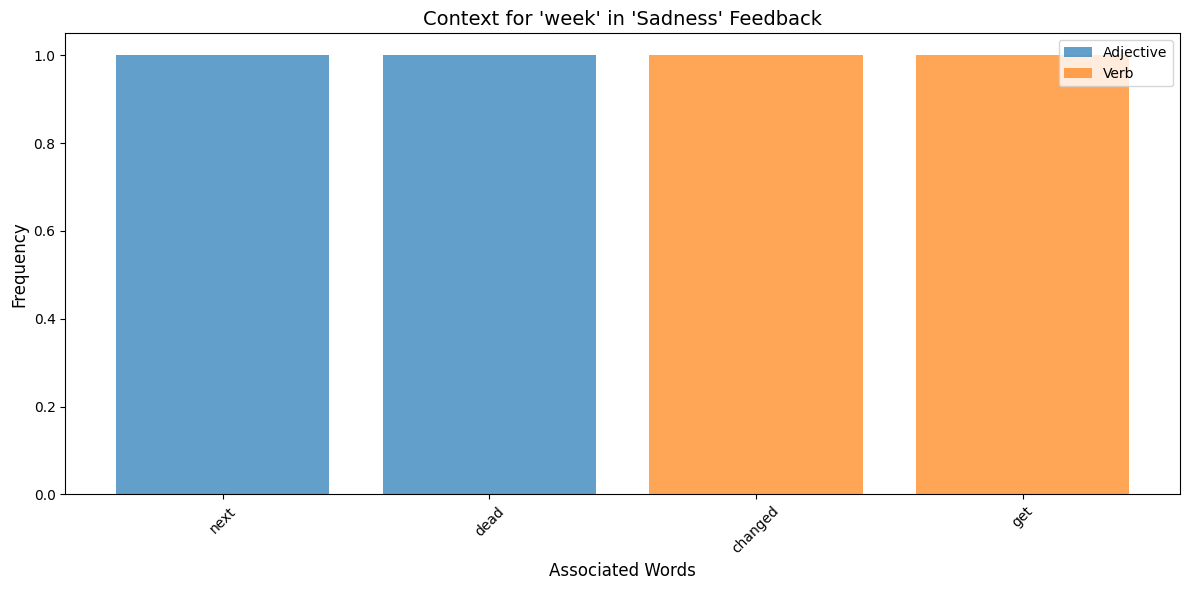

Plotted context for 'week' in 'sadness'.


2025-04-01 14:59:10,655 [INFO] Plotted context for 'week' in 'sadness'.


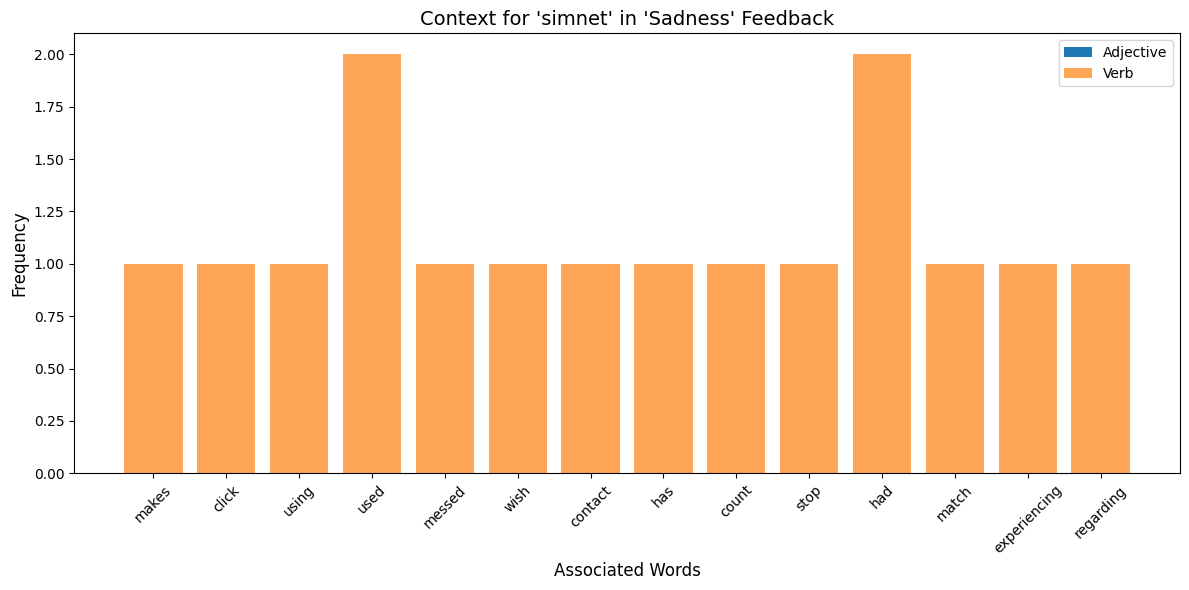

Plotted context for 'simnet' in 'sadness'.


2025-04-01 14:59:10,734 [INFO] Plotted context for 'simnet' in 'sadness'.


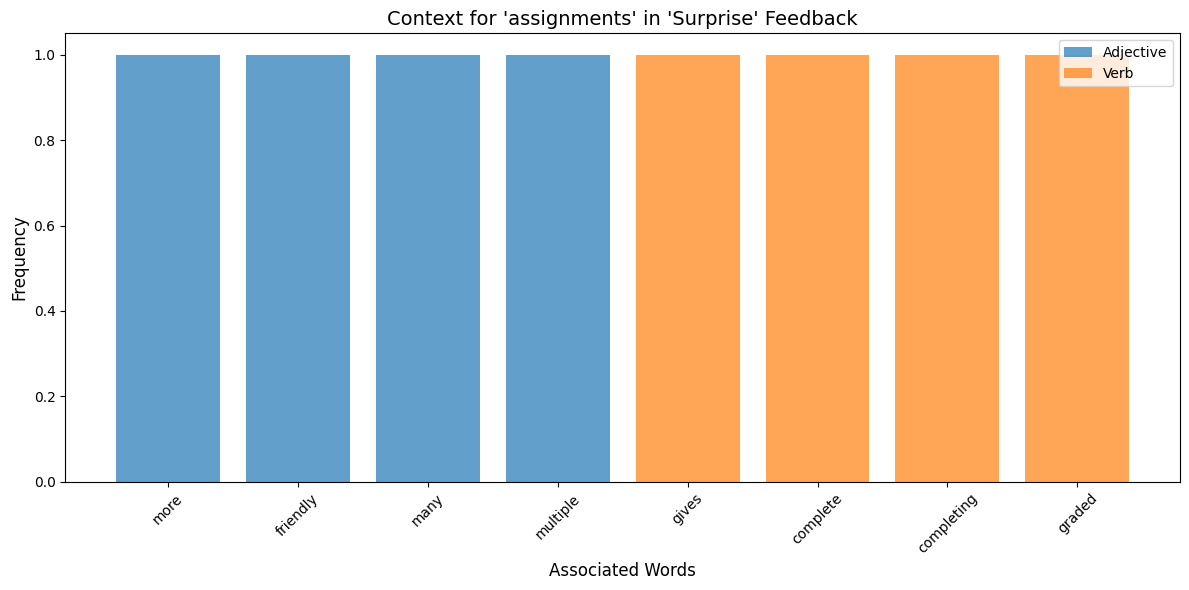

Plotted context for 'assignments' in 'surprise'.


2025-04-01 14:59:10,789 [INFO] Plotted context for 'assignments' in 'surprise'.


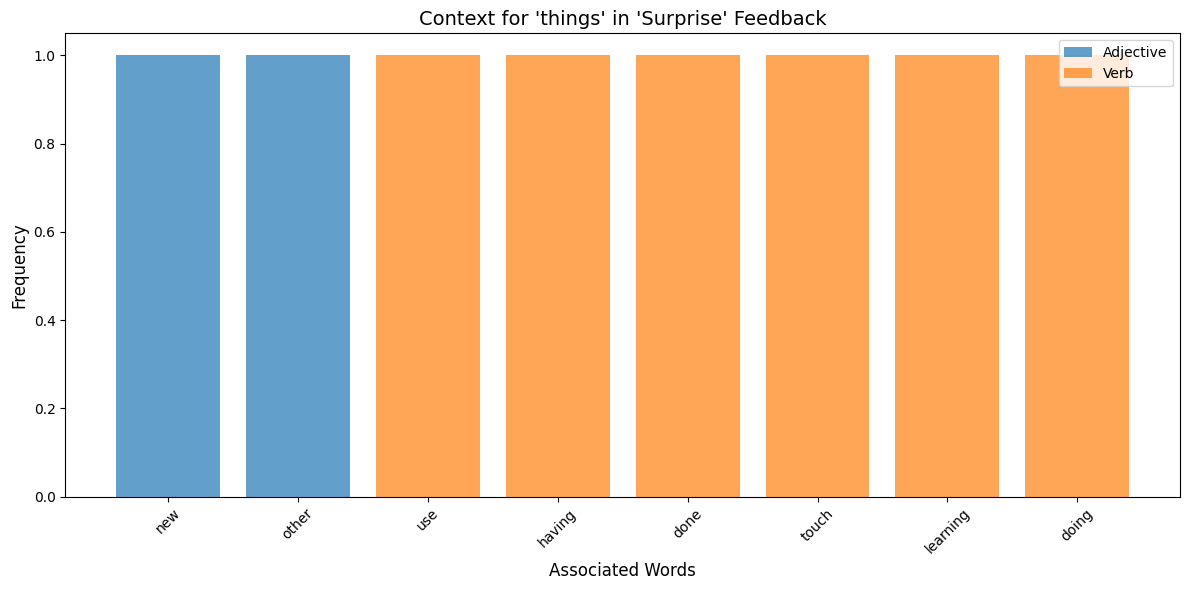

Plotted context for 'things' in 'surprise'.


2025-04-01 14:59:10,843 [INFO] Plotted context for 'things' in 'surprise'.


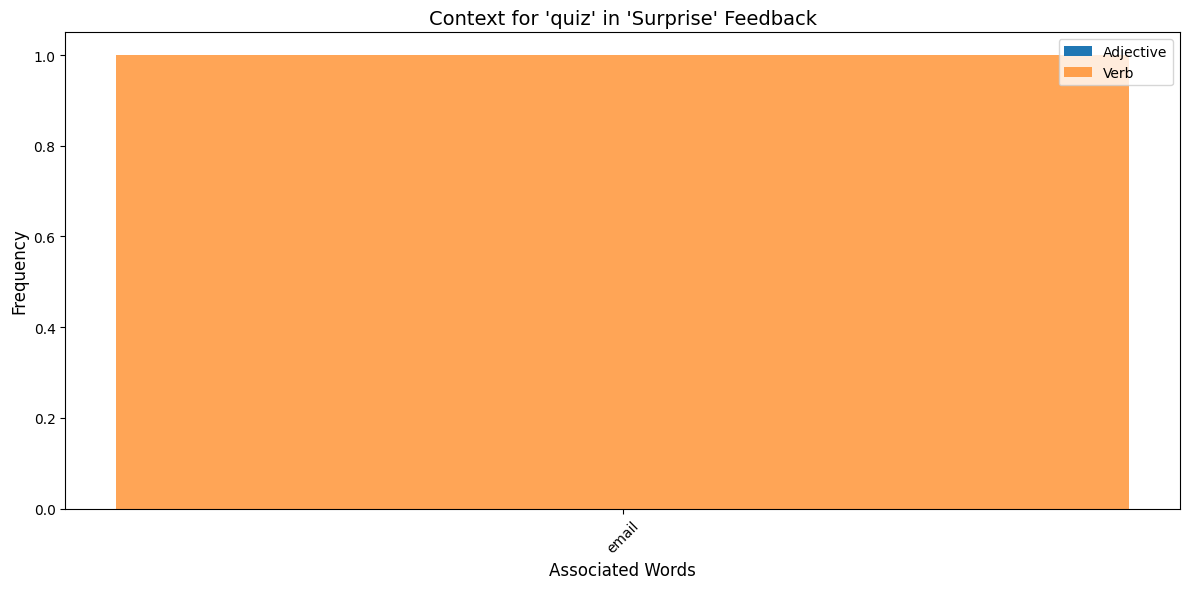

Plotted context for 'quiz' in 'surprise'.


2025-04-01 14:59:10,887 [INFO] Plotted context for 'quiz' in 'surprise'.


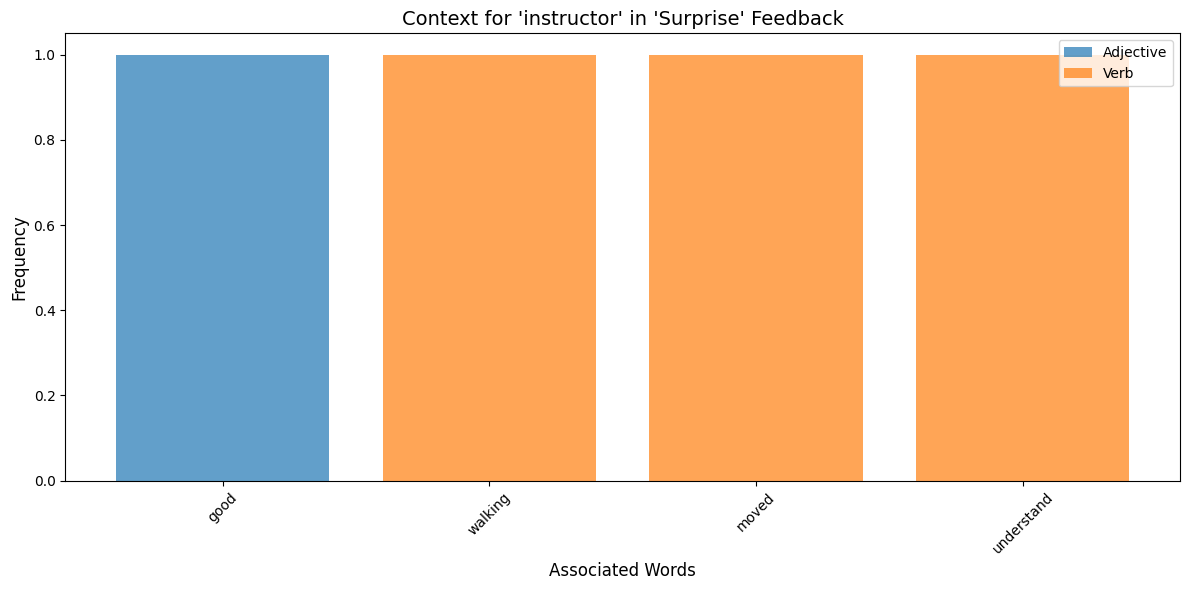

Plotted context for 'instructor' in 'surprise'.


2025-04-01 14:59:10,935 [INFO] Plotted context for 'instructor' in 'surprise'.


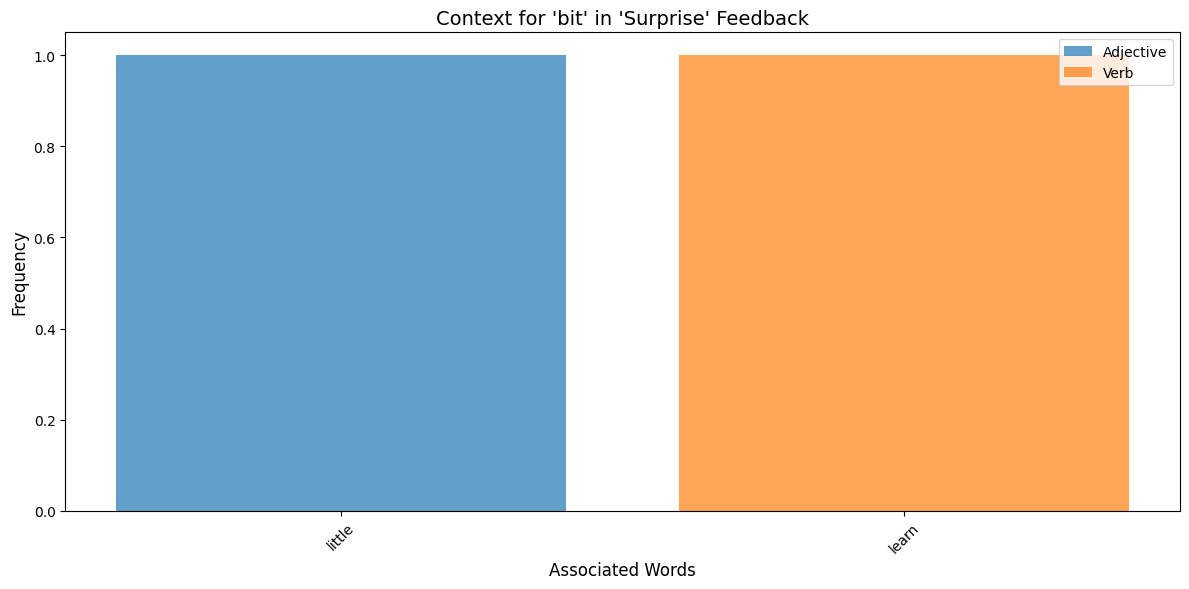

Plotted context for 'bit' in 'surprise'.


2025-04-01 14:59:10,979 [INFO] Plotted context for 'bit' in 'surprise'.


Generating word clouds for each emotion...


2025-04-01 14:59:10,980 [INFO] Generating word clouds for each emotion...


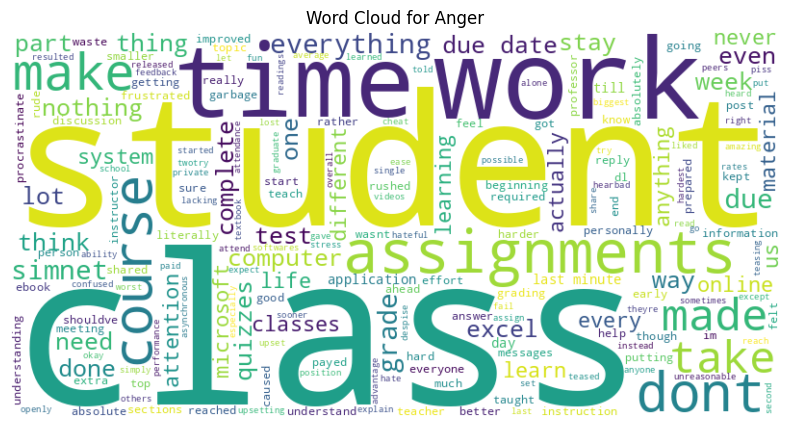

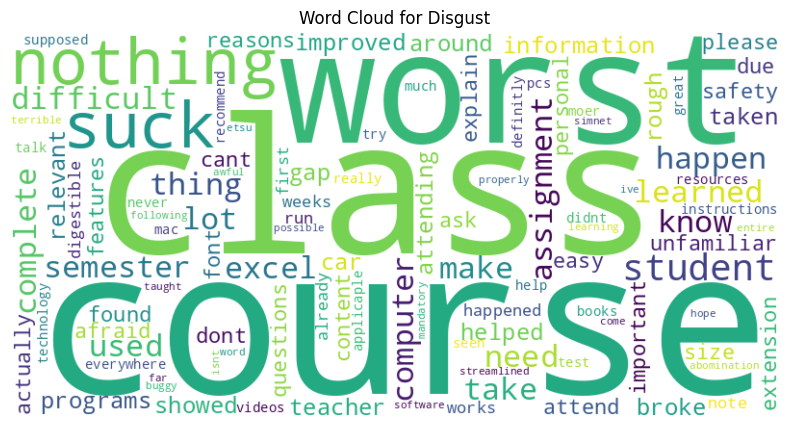

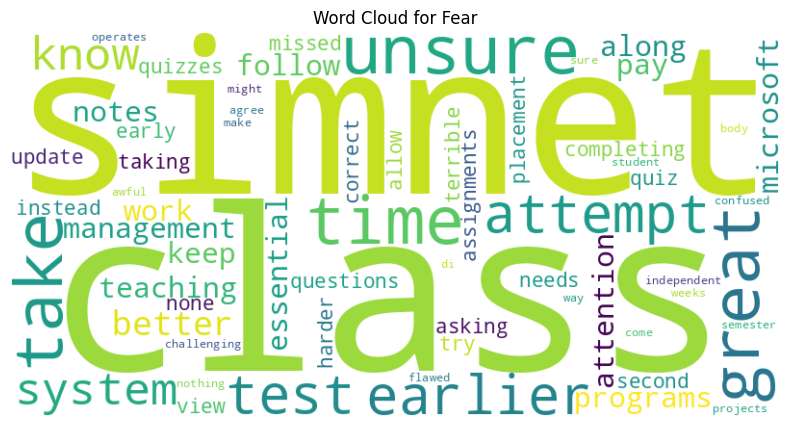

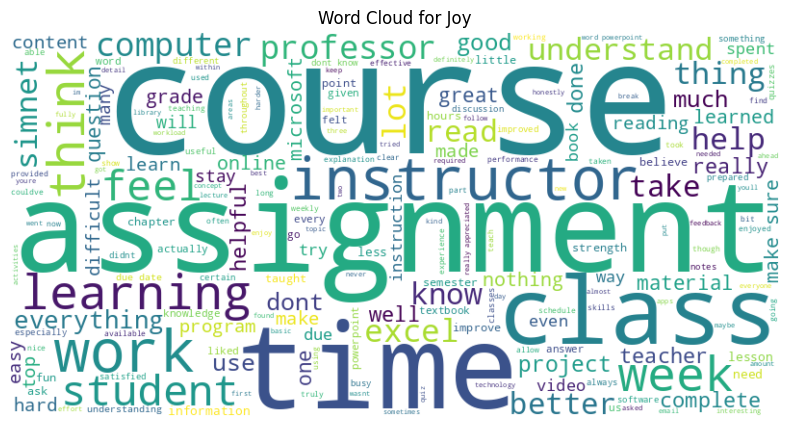

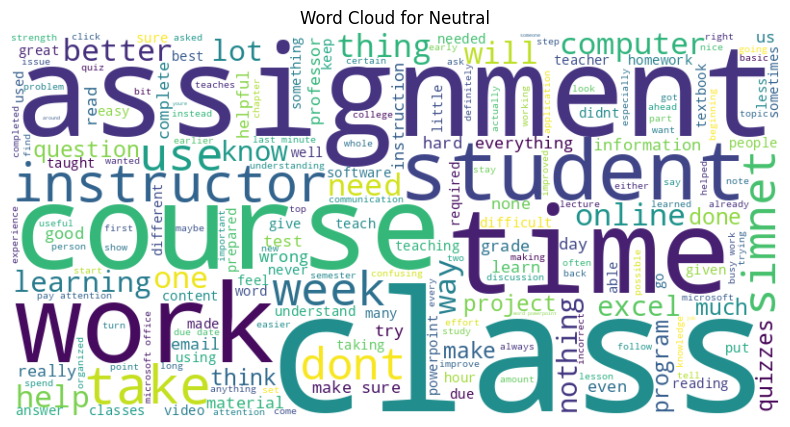

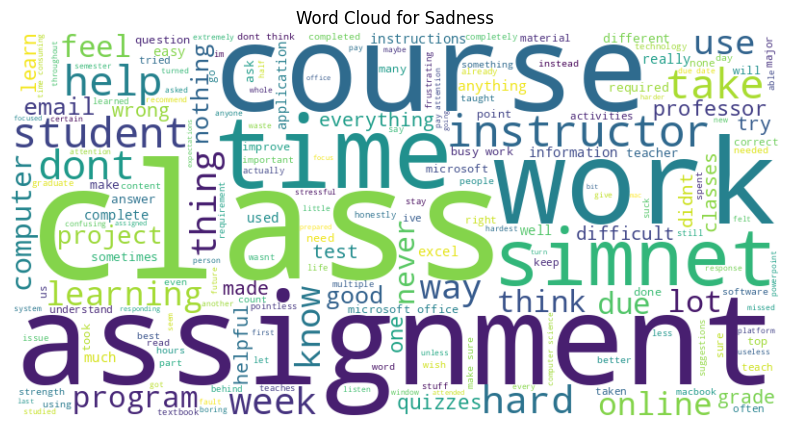

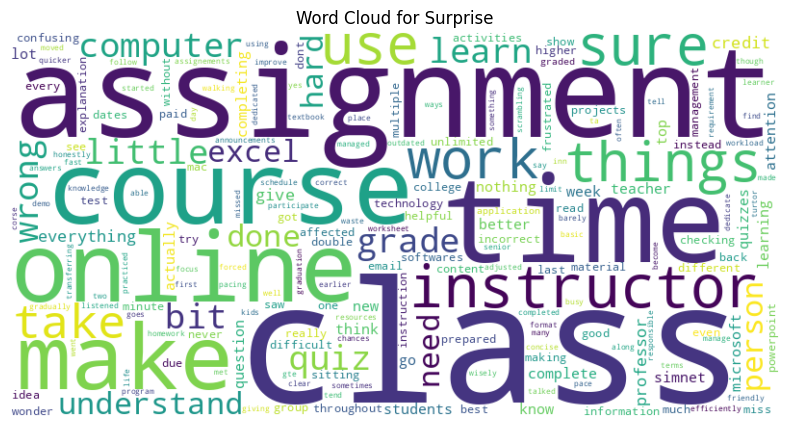

Word clouds generation completed.


2025-04-01 14:59:12,978 [INFO] Word clouds generation completed.


Generating instructor insights with LDA topic modeling...


2025-04-01 14:59:12,979 [INFO] Generating instructor insights with LDA topic modeling...


Processing Anger: 20 responses


2025-04-01 14:59:12,979 [INFO] Processing Anger: 20 responses
2025-04-01 14:59:12,985 [INFO] adding document #0 to Dictionary<0 unique tokens: []>
2025-04-01 14:59:12,986 [INFO] built Dictionary<392 unique tokens: ['ability', 'amazing', 'attend', 'better', 'computer']...> from 20 documents (total 636 corpus positions)
2025-04-01 14:59:12,986 [INFO] Dictionary lifecycle event {'msg': "built Dictionary<392 unique tokens: ['ability', 'amazing', 'attend', 'better', 'computer']...> from 20 documents (total 636 corpus positions)", 'datetime': '2025-04-01T14:59:12.986516', 'gensim': '4.3.3', 'python': '3.11.6 (main, Jan 28 2025, 11:44:45) [Clang 16.0.0 (clang-1600.0.26.4)]', 'platform': 'macOS-15.3-arm64-arm-64bit', 'event': 'created'}
2025-04-01 14:59:12,986 [INFO] using symmetric alpha at 0.3333333333333333
2025-04-01 14:59:12,986 [INFO] using symmetric eta at 0.3333333333333333
2025-04-01 14:59:12,987 [INFO] using serial LDA version on this node
2025-04-01 14:59:12,988 [INFO] running onlin

Insights for Anger:
Top topics: [(0, '0.017*"due" + 0.013*"assignment" + 0.013*"get" + 0.013*"till" + 0.009*"would" + 0.009*"day" + 0.009*"last"'), (1, '0.014*"assignment" + 0.014*"stay" + 0.011*"dont" + 0.011*"due" + 0.011*"test" + 0.011*"student" + 0.008*"learn"'), (2, '0.016*"get" + 0.014*"make" + 0.014*"made" + 0.012*"student" + 0.012*"like" + 0.009*"everything" + 0.009*"take"')]
Interpreted Insight: Anger flares over difficulties with due and assignment, worsened by get and till issues.


2025-04-01 14:59:13,115 [INFO] Insights for Anger:
Top topics: [(0, '0.017*"due" + 0.013*"assignment" + 0.013*"get" + 0.013*"till" + 0.009*"would" + 0.009*"day" + 0.009*"last"'), (1, '0.014*"assignment" + 0.014*"stay" + 0.011*"dont" + 0.011*"due" + 0.011*"test" + 0.011*"student" + 0.008*"learn"'), (2, '0.016*"get" + 0.014*"make" + 0.014*"made" + 0.012*"student" + 0.012*"like" + 0.009*"everything" + 0.009*"take"')]
Interpreted Insight: Anger flares over difficulties with due and assignment, worsened by get and till issues.


Processing Disgust: 6 responses


2025-04-01 14:59:13,116 [INFO] Processing Disgust: 6 responses
2025-04-01 14:59:13,118 [INFO] adding document #0 to Dictionary<0 unique tokens: []>
2025-04-01 14:59:13,118 [INFO] built Dictionary<110 unique tokens: ['actually', 'afraid', 'already', 'also', 'around']...> from 6 documents (total 134 corpus positions)
2025-04-01 14:59:13,118 [INFO] Dictionary lifecycle event {'msg': "built Dictionary<110 unique tokens: ['actually', 'afraid', 'already', 'also', 'around']...> from 6 documents (total 134 corpus positions)", 'datetime': '2025-04-01T14:59:13.118732', 'gensim': '4.3.3', 'python': '3.11.6 (main, Jan 28 2025, 11:44:45) [Clang 16.0.0 (clang-1600.0.26.4)]', 'platform': 'macOS-15.3-arm64-arm-64bit', 'event': 'created'}
2025-04-01 14:59:13,118 [INFO] using symmetric alpha at 1.0
2025-04-01 14:59:13,119 [INFO] using symmetric eta at 1.0
2025-04-01 14:59:13,119 [INFO] using serial LDA version on this node
2025-04-01 14:59:13,119 [INFO] running online (multi-pass) LDA training, 1 topics

Insights for Disgust:
Top topics: [(0, '0.020*"worst" + 0.016*"suck" + 0.016*"also" + 0.016*"nothing" + 0.012*"used" + 0.012*"student" + 0.012*"semester"')]
Interpreted Insight: Disgust surfaces from distaste for worst and suck, alongside also and nothing grievances.


2025-04-01 14:59:13,175 [INFO] Insights for Disgust:
Top topics: [(0, '0.020*"worst" + 0.016*"suck" + 0.016*"also" + 0.016*"nothing" + 0.012*"used" + 0.012*"student" + 0.012*"semester"')]
Interpreted Insight: Disgust surfaces from distaste for worst and suck, alongside also and nothing grievances.


Processing Fear: 4 responses


2025-04-01 14:59:13,176 [INFO] Processing Fear: 4 responses


Insights for Fear: Too few responses (4) to analyze fear meaningfully.


2025-04-01 14:59:13,176 [INFO] Insights for Fear: Too few responses (4) to analyze fear meaningfully.


Processing Joy: 76 responses


2025-04-01 14:59:13,177 [INFO] Processing Joy: 76 responses
2025-04-01 14:59:13,214 [INFO] adding document #0 to Dictionary<0 unique tokens: []>
2025-04-01 14:59:13,216 [INFO] built Dictionary<965 unique tokens: ['another', 'assignment', 'boring', 'content', 'could']...> from 76 documents (total 2938 corpus positions)
2025-04-01 14:59:13,216 [INFO] Dictionary lifecycle event {'msg': "built Dictionary<965 unique tokens: ['another', 'assignment', 'boring', 'content', 'could']...> from 76 documents (total 2938 corpus positions)", 'datetime': '2025-04-01T14:59:13.216190', 'gensim': '4.3.3', 'python': '3.11.6 (main, Jan 28 2025, 11:44:45) [Clang 16.0.0 (clang-1600.0.26.4)]', 'platform': 'macOS-15.3-arm64-arm-64bit', 'event': 'created'}
2025-04-01 14:59:13,217 [INFO] using symmetric alpha at 0.3333333333333333
2025-04-01 14:59:13,217 [INFO] using symmetric eta at 0.3333333333333333
2025-04-01 14:59:13,217 [INFO] using serial LDA version on this node
2025-04-01 14:59:13,218 [INFO] running onl

Insights for Joy:
Top topics: [(0, '0.017*"could" + 0.016*"assignment" + 0.013*"would" + 0.010*"week" + 0.009*"think" + 0.008*"thing" + 0.008*"better"'), (1, '0.016*"instructor" + 0.015*"would" + 0.015*"assignment" + 0.011*"learning" + 0.010*"could" + 0.009*"week" + 0.009*"feel"'), (2, '0.015*"assignment" + 0.012*"instructor" + 0.010*"think" + 0.009*"could" + 0.009*"like" + 0.009*"know" + 0.008*"would"')]
Interpreted Insight: Joy sparkles through engaging could and approachable assignment, boosted by would and week.


2025-04-01 14:59:13,686 [INFO] Insights for Joy:
Top topics: [(0, '0.017*"could" + 0.016*"assignment" + 0.013*"would" + 0.010*"week" + 0.009*"think" + 0.008*"thing" + 0.008*"better"'), (1, '0.016*"instructor" + 0.015*"would" + 0.015*"assignment" + 0.011*"learning" + 0.010*"could" + 0.009*"week" + 0.009*"feel"'), (2, '0.015*"assignment" + 0.012*"instructor" + 0.010*"think" + 0.009*"could" + 0.009*"like" + 0.009*"know" + 0.008*"would"')]
Interpreted Insight: Joy sparkles through engaging could and approachable assignment, boosted by would and week.


Processing Neutral: 468 responses


2025-04-01 14:59:13,687 [INFO] Processing Neutral: 468 responses
2025-04-01 14:59:13,799 [INFO] adding document #0 to Dictionary<0 unique tokens: []>
2025-04-01 14:59:13,804 [INFO] built Dictionary<2034 unique tokens: ['everything', 'ahead', 'ask', 'assignment', 'better']...> from 464 documents (total 12927 corpus positions)
2025-04-01 14:59:13,805 [INFO] Dictionary lifecycle event {'msg': "built Dictionary<2034 unique tokens: ['everything', 'ahead', 'ask', 'assignment', 'better']...> from 464 documents (total 12927 corpus positions)", 'datetime': '2025-04-01T14:59:13.805126', 'gensim': '4.3.3', 'python': '3.11.6 (main, Jan 28 2025, 11:44:45) [Clang 16.0.0 (clang-1600.0.26.4)]', 'platform': 'macOS-15.3-arm64-arm-64bit', 'event': 'created'}
2025-04-01 14:59:13,809 [INFO] using symmetric alpha at 0.3333333333333333
2025-04-01 14:59:13,809 [INFO] using symmetric eta at 0.3333333333333333
2025-04-01 14:59:13,809 [INFO] using serial LDA version on this node
2025-04-01 14:59:13,810 [INFO] ru

Insights for Neutral:
Top topics: [(0, '0.019*"assignment" + 0.011*"dont" + 0.011*"take" + 0.011*"could" + 0.009*"better" + 0.009*"week" + 0.008*"simnet"'), (1, '0.019*"assignment" + 0.012*"use" + 0.011*"would" + 0.010*"simnet" + 0.009*"make" + 0.009*"computer" + 0.009*"take"'), (2, '0.014*"instructor" + 0.013*"week" + 0.011*"assignment" + 0.011*"get" + 0.010*"thing" + 0.009*"student" + 0.009*"question"')]
Interpreted Insight: Neutral sentiments reflect routine assignment and dont, with take and could noted.


2025-04-01 14:59:16,232 [INFO] Insights for Neutral:
Top topics: [(0, '0.019*"assignment" + 0.011*"dont" + 0.011*"take" + 0.011*"could" + 0.009*"better" + 0.009*"week" + 0.008*"simnet"'), (1, '0.019*"assignment" + 0.012*"use" + 0.011*"would" + 0.010*"simnet" + 0.009*"make" + 0.009*"computer" + 0.009*"take"'), (2, '0.014*"instructor" + 0.013*"week" + 0.011*"assignment" + 0.011*"get" + 0.010*"thing" + 0.009*"student" + 0.009*"question"')]
Interpreted Insight: Neutral sentiments reflect routine assignment and dont, with take and could noted.


Processing Sadness: 92 responses


2025-04-01 14:59:16,232 [INFO] Processing Sadness: 92 responses
2025-04-01 14:59:16,256 [INFO] adding document #0 to Dictionary<0 unique tokens: []>
2025-04-01 14:59:16,258 [INFO] built Dictionary<905 unique tokens: ['already', 'asked', 'assignment', 'bit', 'depth']...> from 92 documents (total 2746 corpus positions)
2025-04-01 14:59:16,258 [INFO] Dictionary lifecycle event {'msg': "built Dictionary<905 unique tokens: ['already', 'asked', 'assignment', 'bit', 'depth']...> from 92 documents (total 2746 corpus positions)", 'datetime': '2025-04-01T14:59:16.258703', 'gensim': '4.3.3', 'python': '3.11.6 (main, Jan 28 2025, 11:44:45) [Clang 16.0.0 (clang-1600.0.26.4)]', 'platform': 'macOS-15.3-arm64-arm-64bit', 'event': 'created'}
2025-04-01 14:59:16,259 [INFO] using symmetric alpha at 0.3333333333333333
2025-04-01 14:59:16,260 [INFO] using symmetric eta at 0.3333333333333333
2025-04-01 14:59:16,260 [INFO] using serial LDA version on this node
2025-04-01 14:59:16,260 [INFO] running online (m

Insights for Sadness:
Top topics: [(0, '0.019*"would" + 0.015*"assignment" + 0.011*"simnet" + 0.010*"hard" + 0.009*"program" + 0.008*"dont" + 0.007*"help"'), (1, '0.019*"assignment" + 0.014*"like" + 0.011*"student" + 0.011*"could" + 0.009*"online" + 0.009*"would" + 0.009*"feel"'), (2, '0.015*"assignment" + 0.012*"simnet" + 0.012*"instructor" + 0.010*"dont" + 0.010*"computer" + 0.010*"take" + 0.009*"due"')]
Interpreted Insight: Sadness emerges from overwhelming would and assignment, tied to simnet and hard challenges.


2025-04-01 14:59:16,720 [INFO] Insights for Sadness:
Top topics: [(0, '0.019*"would" + 0.015*"assignment" + 0.011*"simnet" + 0.010*"hard" + 0.009*"program" + 0.008*"dont" + 0.007*"help"'), (1, '0.019*"assignment" + 0.014*"like" + 0.011*"student" + 0.011*"could" + 0.009*"online" + 0.009*"would" + 0.009*"feel"'), (2, '0.015*"assignment" + 0.012*"simnet" + 0.012*"instructor" + 0.010*"dont" + 0.010*"computer" + 0.010*"take" + 0.009*"due"')]
Interpreted Insight: Sadness emerges from overwhelming would and assignment, tied to simnet and hard challenges.


Processing Surprise: 25 responses


2025-04-01 14:59:16,721 [INFO] Processing Surprise: 25 responses
2025-04-01 14:59:16,727 [INFO] adding document #0 to Dictionary<0 unique tokens: []>
2025-04-01 14:59:16,727 [INFO] built Dictionary<319 unique tokens: ['assignements', 'assignment', 'basic', 'complete', 'completed']...> from 25 documents (total 554 corpus positions)
2025-04-01 14:59:16,728 [INFO] Dictionary lifecycle event {'msg': "built Dictionary<319 unique tokens: ['assignements', 'assignment', 'basic', 'complete', 'completed']...> from 25 documents (total 554 corpus positions)", 'datetime': '2025-04-01T14:59:16.728072', 'gensim': '4.3.3', 'python': '3.11.6 (main, Jan 28 2025, 11:44:45) [Clang 16.0.0 (clang-1600.0.26.4)]', 'platform': 'macOS-15.3-arm64-arm-64bit', 'event': 'created'}
2025-04-01 14:59:16,728 [INFO] using symmetric alpha at 0.3333333333333333
2025-04-01 14:59:16,728 [INFO] using symmetric eta at 0.3333333333333333
2025-04-01 14:59:16,728 [INFO] using serial LDA version on this node
2025-04-01 14:59:16,7

Insights for Surprise:
Top topics: [(0, '0.018*"online" + 0.018*"get" + 0.018*"take" + 0.015*"instructor" + 0.015*"person" + 0.012*"could" + 0.011*"bit"'), (1, '0.023*"assignment" + 0.018*"online" + 0.017*"would" + 0.017*"little" + 0.017*"everything" + 0.017*"completing" + 0.012*"could"'), (2, '0.022*"assignment" + 0.019*"make" + 0.016*"quiz" + 0.016*"sure" + 0.014*"use" + 0.011*"grade" + 0.011*"thing"')]
Interpreted Insight: Surprise shines through unexpected online and get, highlighted by take and instructor.


2025-04-01 14:59:16,846 [INFO] Insights for Surprise:
Top topics: [(0, '0.018*"online" + 0.018*"get" + 0.018*"take" + 0.015*"instructor" + 0.015*"person" + 0.012*"could" + 0.011*"bit"'), (1, '0.023*"assignment" + 0.018*"online" + 0.017*"would" + 0.017*"little" + 0.017*"everything" + 0.017*"completing" + 0.012*"could"'), (2, '0.022*"assignment" + 0.019*"make" + 0.016*"quiz" + 0.016*"sure" + 0.014*"use" + 0.011*"grade" + 0.011*"thing"')]
Interpreted Insight: Surprise shines through unexpected online and get, highlighted by take and instructor.


Instructor insights generation completed.


2025-04-01 14:59:16,846 [INFO] Instructor insights generation completed.


Generating emotion transition Sankey diagram...


2025-04-01 14:59:16,846 [INFO] Generating emotion transition Sankey diagram...


No valid transitions found for Sankey diagram.


2025-04-01 14:59:16,850 [WARNING] No valid transitions found for Sankey diagram.


Generating emotion intensity box plot...


2025-04-01 14:59:16,850 [INFO] Generating emotion intensity box plot...


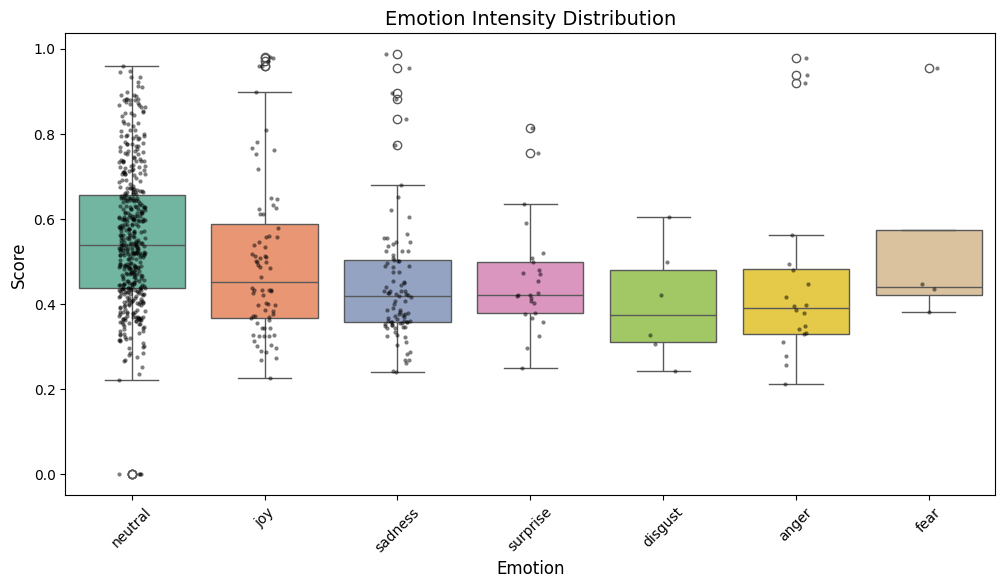

Emotion intensity box plot plotted successfully.


2025-04-01 14:59:16,948 [INFO] Emotion intensity box plot plotted successfully.


Generating cluster emotion pie charts...


2025-04-01 14:59:16,949 [INFO] Generating cluster emotion pie charts...


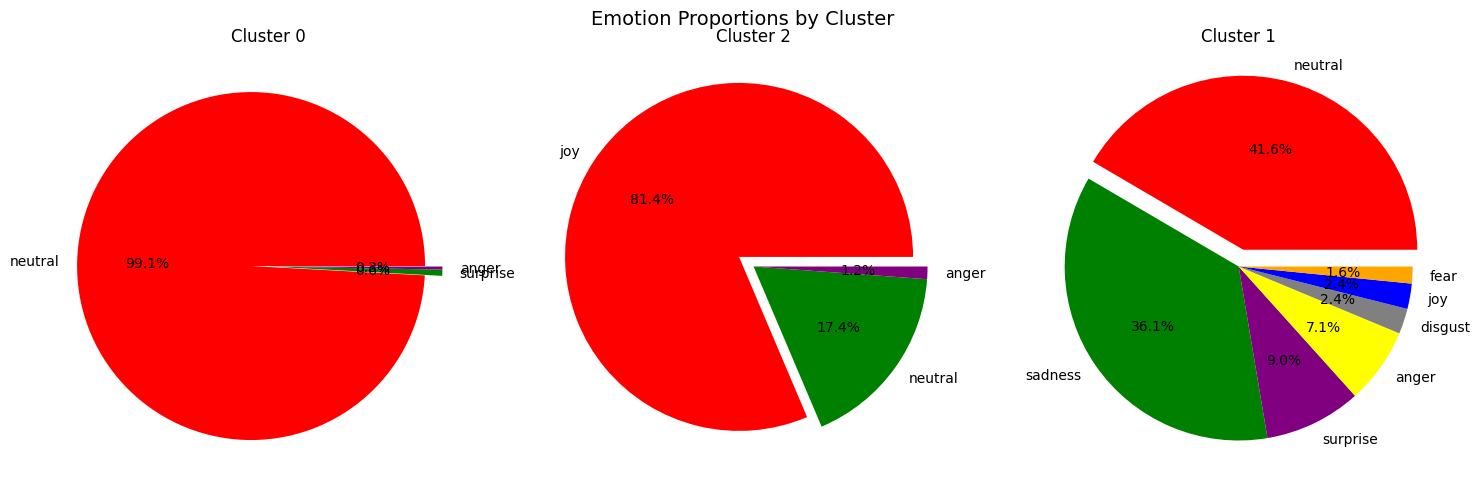

Cluster emotion pie charts plotted successfully.


2025-04-01 14:59:17,019 [INFO] Cluster emotion pie charts plotted successfully.


Generating emotion word bubble chart...


2025-04-01 14:59:17,020 [INFO] Generating emotion word bubble chart...


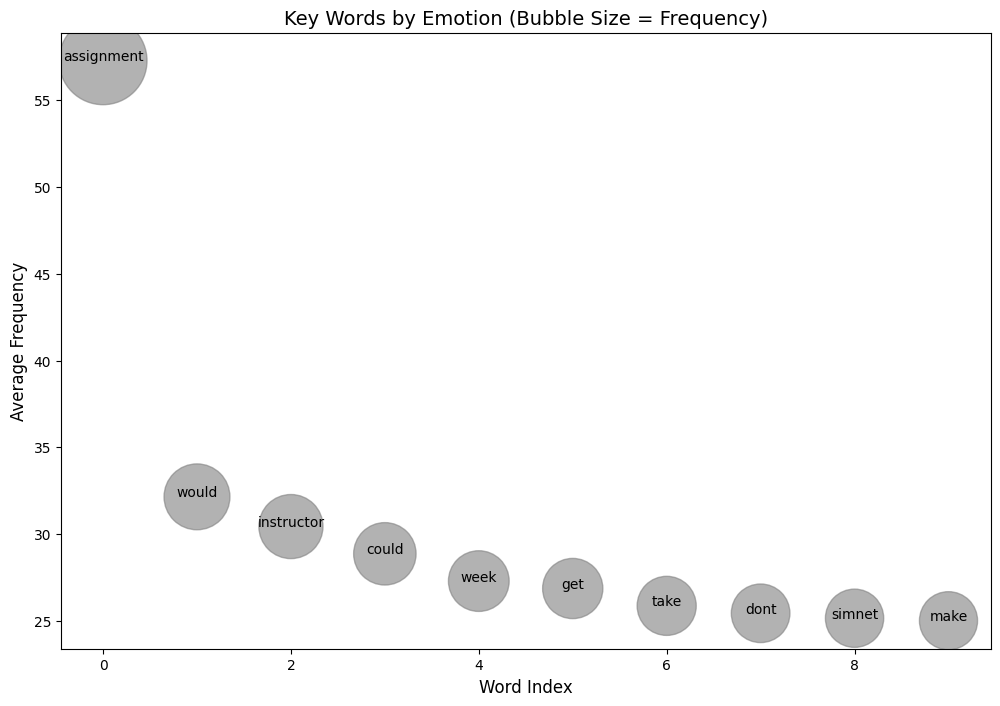

Emotion word bubble chart plotted successfully.


2025-04-01 14:59:17,440 [INFO] Emotion word bubble chart plotted successfully.


Generating interactive emotion trends plot with forecasts...


2025-04-01 14:59:17,441 [INFO] Generating interactive emotion trends plot with forecasts...


Interactive plot with forecasts saved to emotion_trends_with_forecasts.html


2025-04-01 14:59:17,475 [INFO] Interactive plot with forecasts saved to emotion_trends_with_forecasts.html


Generating stacked area chart...


2025-04-01 14:59:17,476 [INFO] Generating stacked area chart...


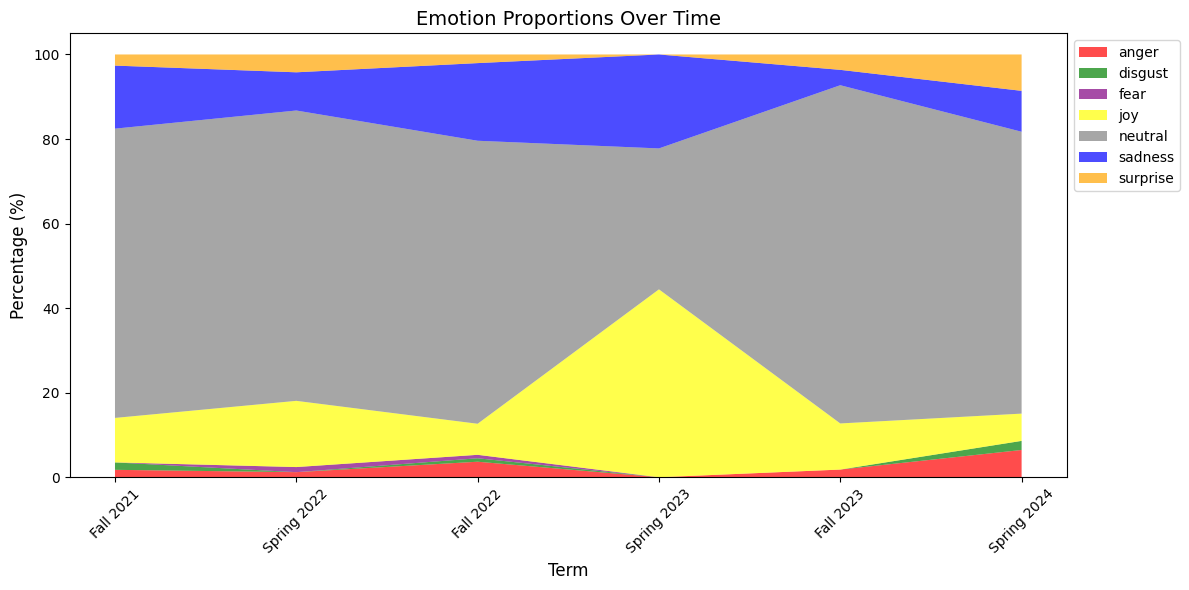

Stacked area chart plotted successfully.


2025-04-01 14:59:17,572 [INFO] Stacked area chart plotted successfully.


Generating correlation heatmap...


2025-04-01 14:59:17,572 [INFO] Generating correlation heatmap...


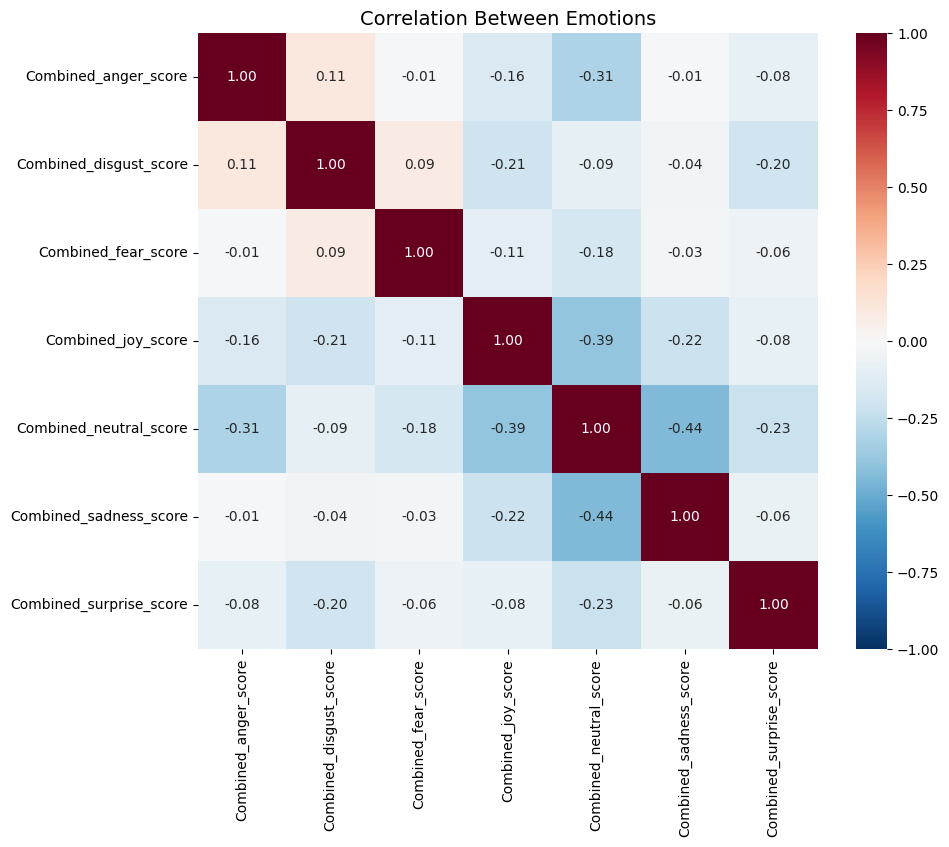

Correlation heatmap plotted successfully.


2025-04-01 14:59:17,660 [INFO] Correlation heatmap plotted successfully.


Generating radar chart...


2025-04-01 14:59:17,660 [INFO] Generating radar chart...


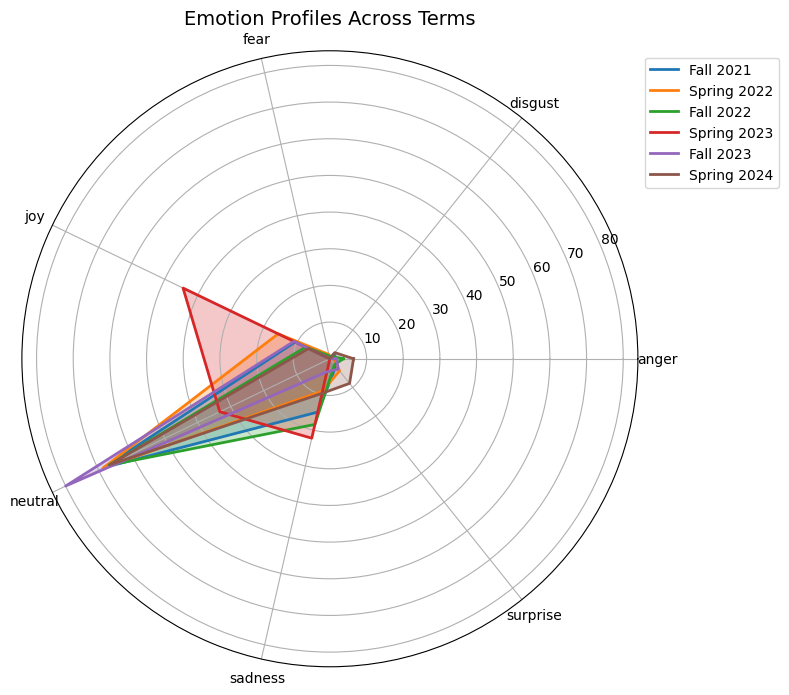

Radar chart plotted successfully.


2025-04-01 14:59:17,739 [INFO] Radar chart plotted successfully.


Generating timeline with annotations...


2025-04-01 14:59:17,739 [INFO] Generating timeline with annotations...


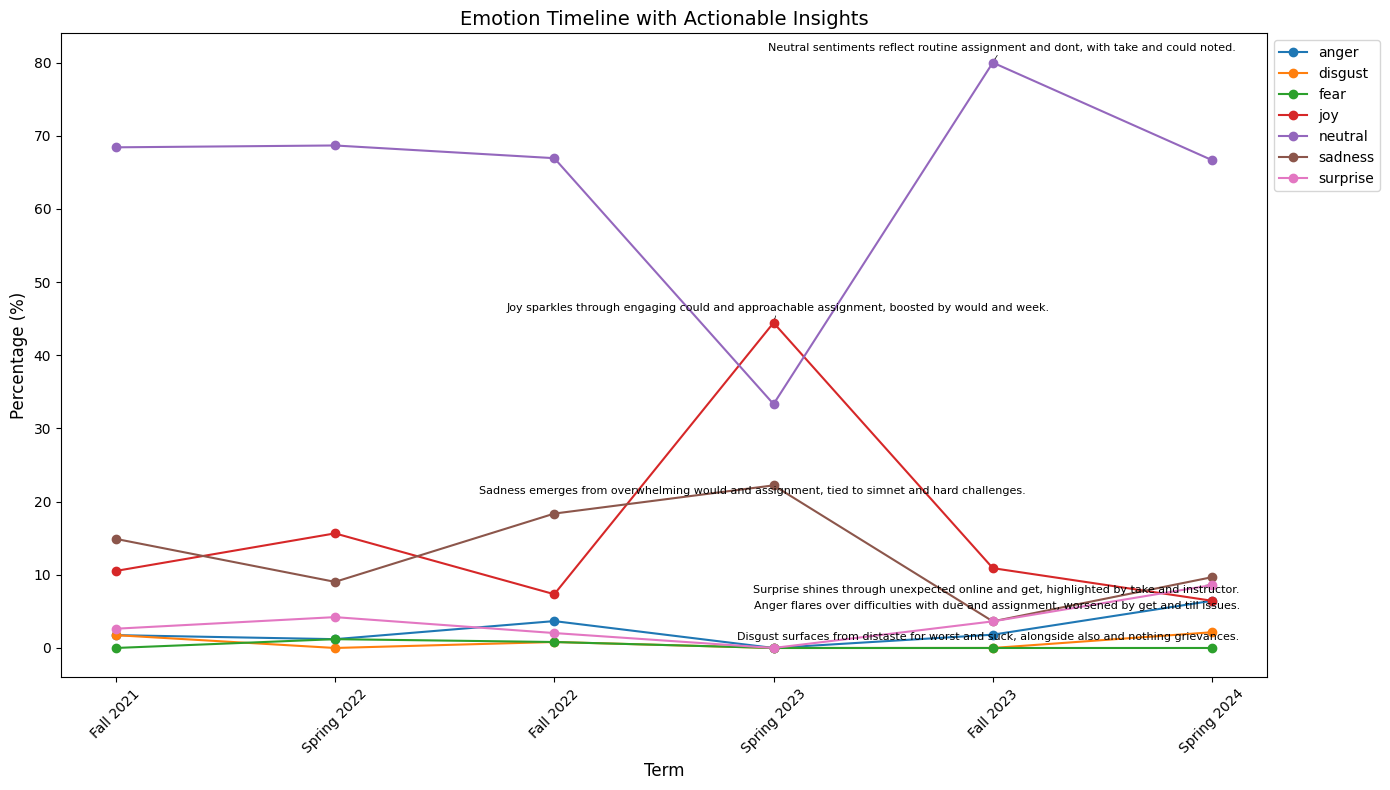

Timeline with annotations plotted successfully.


2025-04-01 14:59:17,883 [INFO] Timeline with annotations plotted successfully.


Pipeline completed successfully. Final data saved to Final_Enhanced_Model.xlsx


2025-04-01 14:59:17,980 [INFO] Pipeline completed successfully. Final data saved to Final_Enhanced_Model.xlsx


In [41]:
if __name__ == "__main__":
    # Note: Updated file path to match your latest input
    model = EmotionTrajectoryModel("Sentiment Data Collection Sheet.xlsx")
    model.run()